I present this project in order to obtain my data science certification from GoMyCode School. It represent for me the opportunity to use all the knowledge I've learnt from this program to create a Weather Prediction App.

This project go though the following steps :

* Search and select an API key to request historical weather data ;
* Set environment ;
* Request and describe the data ;
* Clean and Explore the data ;
* Determine target parameter and their acording features ;
* split data (using cross validation) & Create, fit, train and evaluate prediction models  ;
* Predict and save the future values ;
* Return the forecast trough a streamlit App.

# **Step 0 : Set Environment**

## *1. import labraries*
This step consist on importing the packedges, libraries and functions needed to process data and  build the model.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import json
import xgboost as xgb
import sqlite3
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## 2. *Set useful fonctions*
The process of building a weather parameter prediction model requires several iterations and round trips to obtain the best modeling accurancy. For this purpose, i have preset functions to facilitate my work.

In [2]:
# Create high correlated target features list
def create_basefeatures(target_column, columns_to_drop,threshold, df):
  # Create corr_matrix
  corr_matrix = df.drop(columns_to_drop, axis=1).corr()
  # Filter columns based on correlation with the target column
  selected_columns = corr_matrix[abs(corr_matrix[target_column]) > threshold].index.tolist()
  # Return the selected columns
  return selected_columns

In [3]:
# Create TARGET dataframe
def timeserie_df(FEATURES, df):
  new_columns = FEATURES
  df = df[new_columns]
  df = pd.DataFrame(df)
  return df

In [4]:
# Create temporel features
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [5]:
# Add lags
def add_lags(df, target_name):
    """
    Add lags according to What was the target (x) days in the past.
    """
    target_map = df[target_name].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('1820 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('3640 days')).map(target_map)
    return df

In [6]:
# Model regression function
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=600,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)

In [7]:
# create model function
def model_function(df,FEATURES, TARGET, estimators):
  tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=1)
  df = df.sort_index()


  fold = 0
  preds = []
  mses = []
  maes = []
  r2s = []
  for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=estimators,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)
  return preds, mses, maes, r2s

In [8]:
# Create evaluation function
def evaluation(mses, r2s):
  print(f'MSEs across folds {np.mean(mses):0.4f}')
  print(f'Fold mses:{mses}')
  print(f'R2s across folds {np.mean(r2s):0.4f}')
  print(f'Fold R2s:{r2s}')

In [9]:
# function to retrain on all data
def train_all(df, FEATURES, TARGET, estimators):
  df = create_features(df)

  X_all = df[FEATURES]
  y_all = df[TARGET]

  reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=estimators,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
  reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)
  reg.save_model(f'{TARGET}_model.json')

In [10]:
# Create TARGET predection values
def param_pred(df, pred_name, TARGET, FEATURES ):
  reg_new = xgb.XGBRegressor()
  reg_new.load_model(f'{TARGET}_model.json')
  df[pred_name] = reg_new.predict(df[FEATURES])
  return df[pred_name]

In [11]:
# Create TARGET & TARGET_Pred dataframe
def create_target_df(df, TARGET, TARGET_pred):
  target_df = pd.DataFrame(df[TARGET], index=df.index)
  target_df[TARGET_pred] = df[TARGET_pred]
  return target_df

In [12]:
# Visualize TARGET Vs TARGET_Pred
def data_viz(df, TARGET, pred_name):
  ax = df[[TARGET]].plot(style='o', figsize=(10, 5))
  df[pred_name].plot(ax=ax, style='.')
  plt.legend(['Truth Data', 'Predictions'])
  ax.set_title('Raw Data and Prediction')
  plt.show()

In [13]:
# Create future dataframe
def create_futur_df(df, target_name):
  future = pd.date_range('2023-06-25','2024-06-25', freq='D')
  future_df = pd.DataFrame(index=future)
  future_df['isFuture'] = True
  df['isFuture'] = False
  df_and_future = pd.concat([df, future_df])
  df_and_future = create_features(df_and_future)
  df_and_future = add_lags(df_and_future, target_name)
  future_w_features = df_and_future.query('isFuture').copy()
  return future_w_features

In [14]:
# visualize predections
def future_pred_viz(df, pred_name):
  df[pred_name].plot(figsize=(10, 5),
                  color=color_pal[4],
                  ms=1,
                  lw=1,
                  title=f'Future {pred_name} Predictions')
  plt.show()

# **Step1 : Describe and request the data**

## 1. Describe the data

* Data Source :
I have choose Open-Meteo API since it is a free and an open-source weather API and offers free access for non-commercial use.
It provide comprehensive weather information worldwide, seamless integration and deliver the data in a simple and accessible format (json).
Additionally, it guaranteed up-to-date weather information and rely on a wealth of real-time data.
it also provide 80 Years of hourly and daily weather data available at a 10 kilometer resolution and continuously archive recent data.
The Historical Weather API is based on reanalysis datasets and uses a combination of weather station, aircraft, buoy, radar, and satellite observations to create a comprehensive record of past weather conditions. These datasets are able to fill in gaps by using mathematical models to estimate the values of various weather variables.

* Data documentation :    
The API endpoint allows users to retrieve historical weather data for a specific location and time period. To use this endpoint, you can specify a geographical coordinate, a time interval, and a list of weather variables that you are interested in. The endpoint will then return the requested data in a format that can be easily accessed and used by applications or other software.

* Daily parameter definition :    
Aggregations are a simple 24 hour aggregation from hourly values. The historical data API provide to the user to choose the daily parameters to be request.
The following parameters daily data are available :    
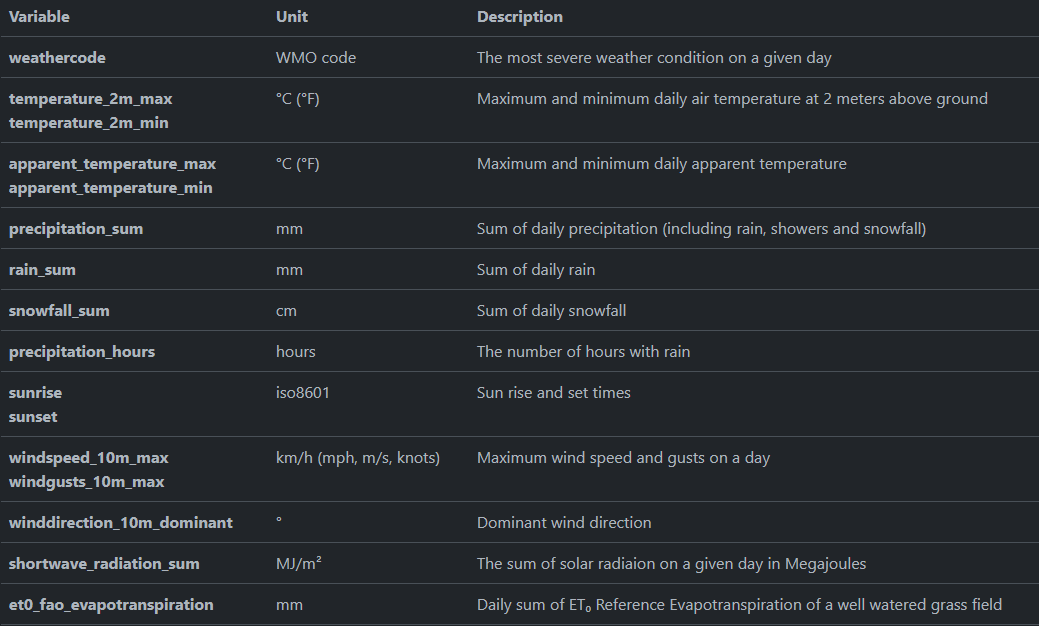

To discover the All URL parameters and more details about the data documentation check the link : [API Documentation](https://open-meteo.com/en/docs/historical-weather-api)


## 2. Request Data

In [15]:
# Request data
url_API = "https://archive-api.open-meteo.com/v1/archive?latitude=36.6985&longitude=3.2067&start_date=1990-01-01&end_date=2023-06-25&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,precipitation_hours,windspeed_10m_max,winddirection_10m_dominant&timezone=GMT"
weather_data = requests.get(url_API)
if weather_data.status_code == 200:
  weather_data = json.loads(weather_data.text)
else:
  print('The data are not available!')
# Create a data frame
weather_df = pd.DataFrame()
# Extract data from dictionary
time = weather_data['daily']['time']
weathercode = weather_data['daily']['weathercode']
temperature_2m_max = weather_data['daily']['temperature_2m_max']
temperature_2m_min = weather_data['daily']['temperature_2m_min']
temperature_2m_mean = weather_data['daily']['temperature_2m_mean']
apparent_temperature_mean = weather_data['daily']['apparent_temperature_mean']
sunrise = weather_data['daily']['sunrise']
sunset = weather_data['daily']['sunset']
precipitation_sum = weather_data['daily']['precipitation_sum']
precipitation_hours = weather_data['daily']['precipitation_hours']
rain_sum = weather_data['daily']['rain_sum']
windspeed_10m_max = weather_data['daily']['windspeed_10m_max']
winddirection_10m_dominant = weather_data['daily']['winddirection_10m_dominant']
# Create and add dataframe columns
weather_df['time'] = time
weather_df['weathercode'] = weathercode
weather_df['temperature_2m_max'] = temperature_2m_max
weather_df['temperature_2m_min'] = temperature_2m_min
weather_df['temperature_2m_mean'] = temperature_2m_mean
weather_df['apparent_temperature_mean'] = apparent_temperature_mean
weather_df['sunrise'] = sunrise
weather_df['sunset'] = sunset
weather_df['precipitation_sum'] = precipitation_sum
weather_df['precipitation_hours'] = precipitation_hours
weather_df['rain_sum'] = rain_sum
weather_df['windspeed_10m_max'] = windspeed_10m_max
weather_df['winddirection_10m_dominant'] = winddirection_10m_dominant


# **Step 2 : Clean and Explore the data**

## 1. Check and prepare data for use

In [16]:
# Check the data
weather_df.head()

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,sunrise,sunset,precipitation_sum,precipitation_hours,rain_sum,windspeed_10m_max,winddirection_10m_dominant
0,1990-01-01,55,14.9,9.8,12.2,11.2,1990-01-01T06:59,1990-01-01T16:41,9.9,24.0,9.9,14.0,279
1,1990-01-02,53,15.5,10.0,12.5,11.0,1990-01-02T06:59,1990-01-02T16:42,4.1,15.0,4.1,13.9,250
2,1990-01-03,51,19.1,8.0,12.3,10.7,1990-01-03T06:59,1990-01-03T16:43,1.2,4.0,1.2,12.0,168
3,1990-01-04,55,14.0,10.0,11.7,10.6,1990-01-04T07:00,1990-01-04T16:44,8.4,19.0,8.4,11.7,310
4,1990-01-05,55,13.3,9.6,11.1,9.9,1990-01-05T07:00,1990-01-05T16:44,6.9,20.0,6.9,15.2,27


In [17]:
# Check the data
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12229 entries, 0 to 12228
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time                        12229 non-null  object 
 1   weathercode                 12229 non-null  int64  
 2   temperature_2m_max          12229 non-null  float64
 3   temperature_2m_min          12229 non-null  float64
 4   temperature_2m_mean         12229 non-null  float64
 5   apparent_temperature_mean   12229 non-null  float64
 6   sunrise                     12229 non-null  object 
 7   sunset                      12229 non-null  object 
 8   precipitation_sum           12229 non-null  float64
 9   precipitation_hours         12229 non-null  float64
 10  rain_sum                    12229 non-null  float64
 11  windspeed_10m_max           12229 non-null  float64
 12  winddirection_10m_dominant  12229 non-null  int64  
dtypes: float64(8), int64(2), object

In [18]:
# Check the data metrics
weather_df.describe()

,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,precipitation_sum,precipitation_hours,rain_sum,windspeed_10m_max,winddirection_10m_dominant
count,12229.000000,12229.000000,12229.000000,12229.000000,12229.000000,12229.000000,12229.000000,12229.000000,12229.000000,12229.000000
mean,19.980293,23.407417,13.585894,18.283686,17.769352,1.599321,2.747077,1.597858,17.832709,168.077602
std,25.734497,6.896791,5.430738,6.041299,7.646628,4.292658,5.298150,4.288828,6.190880,102.455786
min,0.000000,4.300000,-1.600000,2.300000,-1.900000,0.000000,0.000000,0.000000,5.200000,0.000000
25%,1.000000,17.700000,9.100000,13.100000,11.100000,0.000000,0.000000,0.000000,13.200000,68.000000
50%,2.000000,22.700000,13.200000,17.500000,16.800000,0.000000,0.000000,0.000000,16.700000,170.000000
75%,51.000000,29.200000,18.200000,23.600000,24.600000,0.700000,3.000000,0.700000,21.400000,260.000000
max,73.000000,43.400000,31.000000,35.500000,36.200000,58.000000,24.000000,58.000000,49.000000,360.000000


In [19]:
# Set datetime as index
weather_df = weather_df.set_index('time')
weather_df.index = pd.to_datetime(weather_df.index)
# Check null values
weather_df.apply(pd.isnull).sum()
weather_df['weathercode'][weather_df['weathercode']==0].count()
weather_df['winddirection_10m_dominant'][weather_df['winddirection_10m_dominant']==0].count()
# Fix datatype
weather_df['sunrise'] = pd.to_datetime(weather_df['sunrise'])
weather_df['sunset'] = pd.to_datetime(weather_df['sunset'])

## 2. Visualize the data distribution and evolution (For each parameter)

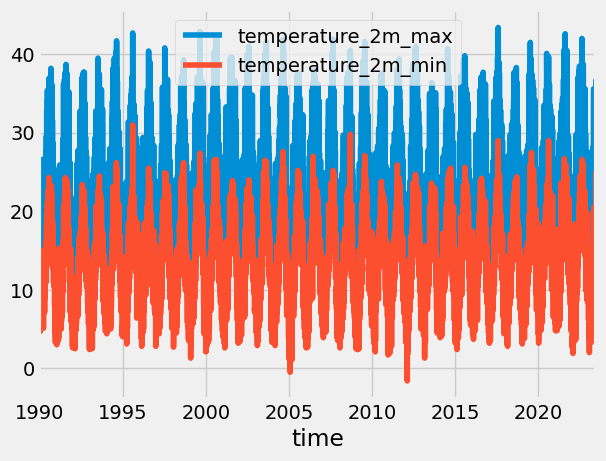

In [20]:
# Max and Min temperature evolution over the last 33 years
weather_df[["temperature_2m_max", "temperature_2m_min"]].plot()
plt.show()

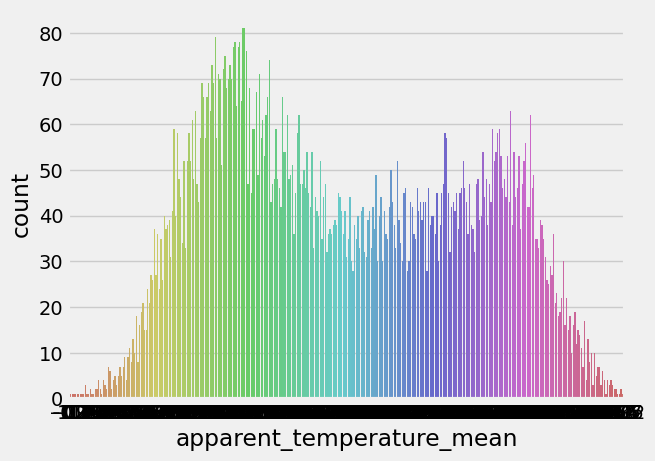

In [21]:
# The mean apparent temperature occurrence over the last 33 years
warnings.filterwarnings('ignore')
sns.countplot(data=weather_df, x=weather_df['apparent_temperature_mean'],palette='hls')
plt.show()

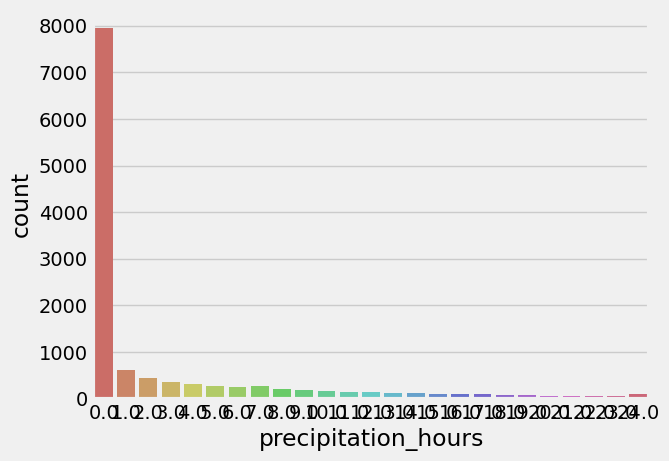

In [22]:
# The precipitation_hours occurrence over the last 33 years
warnings.filterwarnings('ignore')
sns.countplot(data=weather_df, x=weather_df['precipitation_hours'],palette='hls')
plt.show()

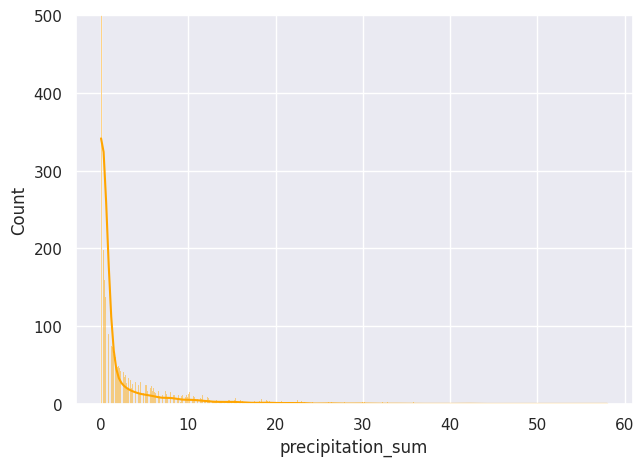

In [23]:
# The precipitation sum occurrence over the last 33 years
sns.set(style='darkgrid')
sns.histplot(data=weather_df,x=weather_df['precipitation_sum'],kde=True,color='orange')
plt.ylim(0, 500)
plt.show()

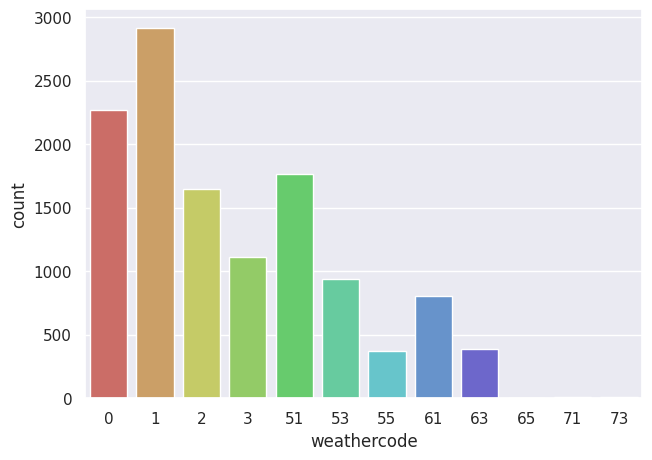

In [24]:
# The weather code occurrence over the last 33 years
warnings.filterwarnings('ignore')
sns.countplot(data=weather_df, x=weather_df['weathercode'],palette='hls')
plt.show()

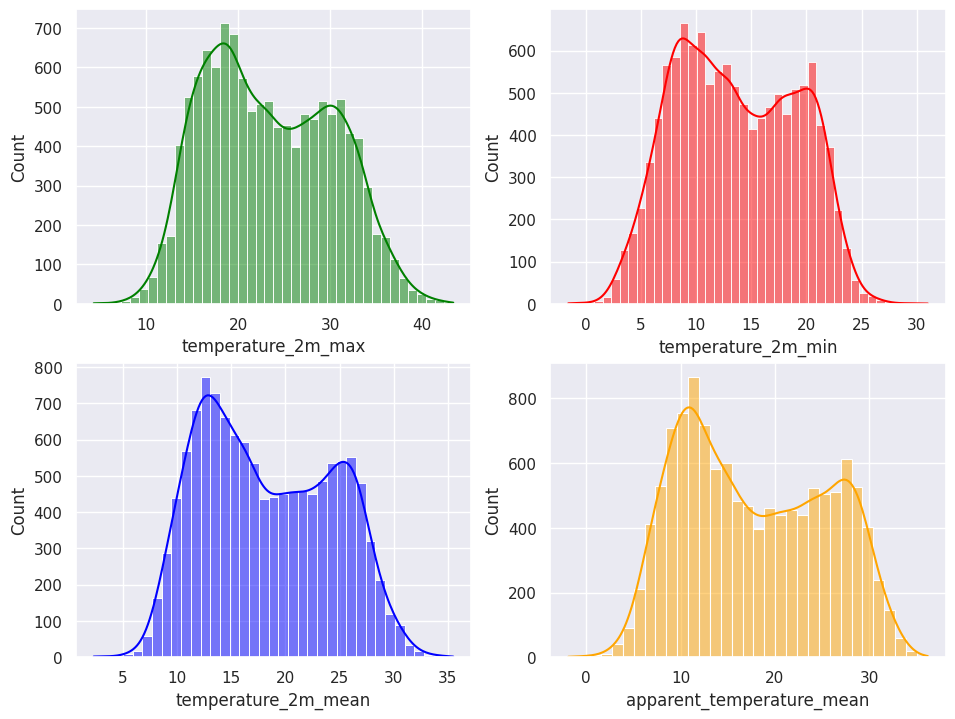

In [25]:
# Visualize the temperature_2m_max, temperature_2m_min, temperature_2m_mean and apparent_temperature_mean distribution
sns.set(style='darkgrid')
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=weather_df,x=weather_df['temperature_2m_max'],kde=True,ax=axs[0,0],color='green')
sns.histplot(data=weather_df,x=weather_df['temperature_2m_min'],kde=True,ax=axs[0,1],color='red')
sns.histplot(data=weather_df,x=weather_df['temperature_2m_mean'],kde=True,ax=axs[1,0],color='blue')
sns.histplot(data=weather_df,x=weather_df['apparent_temperature_mean'],kde=True,ax=axs[1,1],color='orange')

plt.show()

<Axes: ylabel='Frequency'>

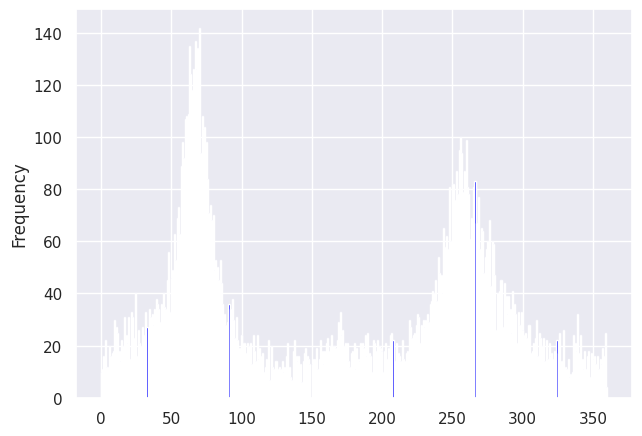

In [26]:
# Visualize the  winddirection_10m_dominant distribution
weather_df['winddirection_10m_dominant'].plot(kind='hist', bins=500, color='blue')

<Axes: ylabel='Frequency'>

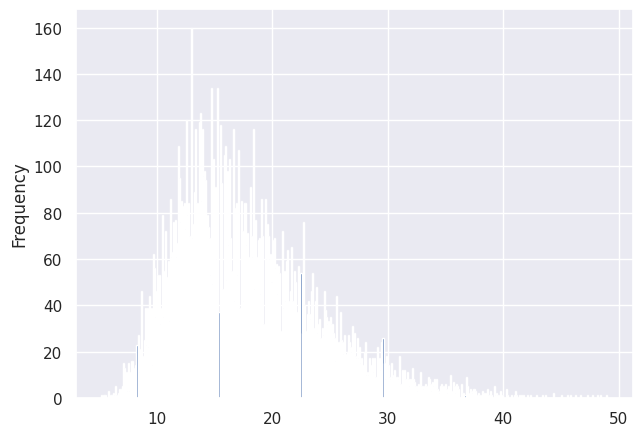

In [27]:
# Visualize the windspeed_10m_max distribution
weather_df['windspeed_10m_max'].plot(kind='hist', bins=500)

## 3. Do correlation analysis

The heatmap Analysis reveal three correlation degree between different parameters.
* High correlation (abs_cor > 0.6)     
* Medium correlation (0.2 < abs_cor < 0.6)    
* Low correlation (abs_cor < 0.2)  


<Axes: >

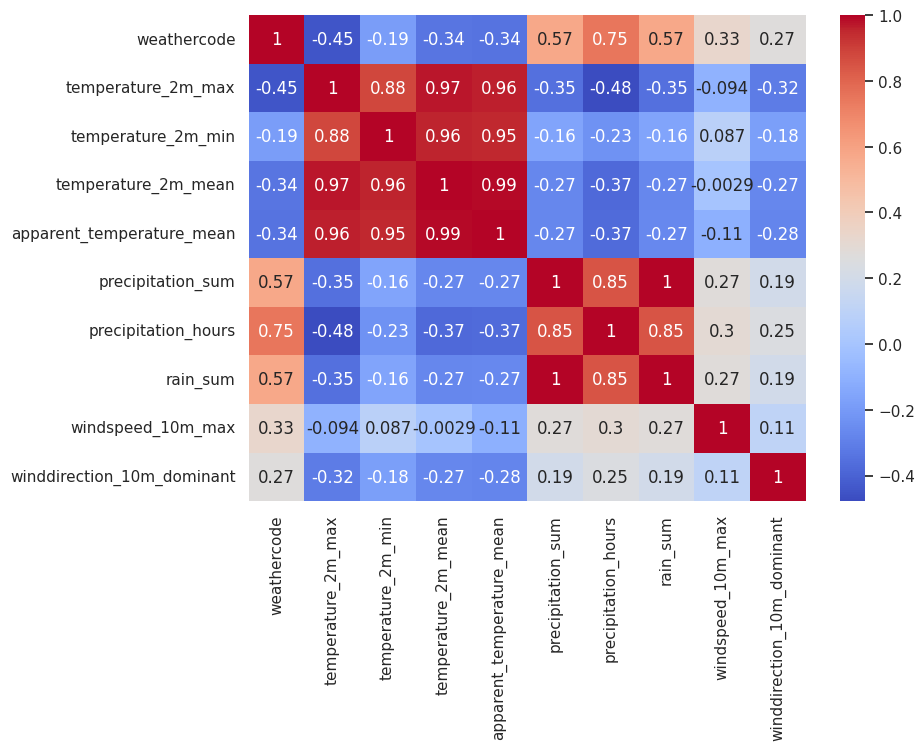

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(weather_df.corr(),annot=True,cmap='coolwarm')

In [29]:
columns_to_drop = ['sunrise', 'sunset', 'rain_sum']
threshold = 0.2
parameters = ['weathercode', 'temperature_2m_max', 'temperature_2m_min',
              'temperature_2m_mean', 'apparent_temperature_mean',
              'precipitation_sum', 'precipitation_hours',
              'windspeed_10m_max', 'winddirection_10m_dominant']
for parameter in parameters:
  cor_parameter = create_basefeatures(parameter, columns_to_drop,threshold, weather_df)
  print(f'The {parameter} is highly or relatively explained by : \n {cor_parameter}\n')

The weathercode is highly or relatively explained by : 
 ['weathercode', 'temperature_2m_max', 'temperature_2m_mean', 'apparent_temperature_mean', 'precipitation_sum', 'precipitation_hours', 'windspeed_10m_max', 'winddirection_10m_dominant']

The temperature_2m_max is highly or relatively explained by : 
 ['weathercode', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_mean', 'precipitation_sum', 'precipitation_hours', 'winddirection_10m_dominant']

The temperature_2m_min is highly or relatively explained by : 
 ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_mean', 'precipitation_hours']

The temperature_2m_mean is highly or relatively explained by : 
 ['weathercode', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_mean', 'precipitation_sum', 'precipitation_hours', 'winddirection_10m_dominant']

The apparent_temperature_mean is highly or relatively explained by : 

## 4. Visualize outliers

By analysing the distribution plot of each parameter, i did detemine the potentiel exterme values which i used to plot the outliers

<Axes: title={'center': 'Outliers'}, xlabel='time'>

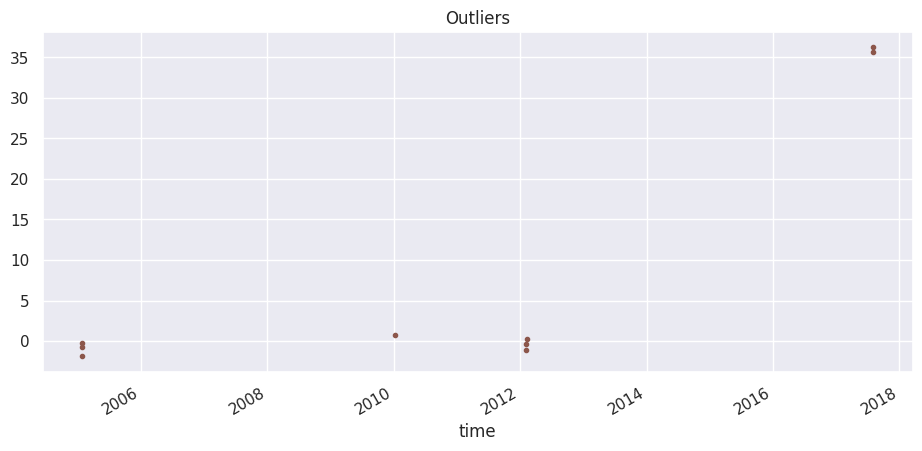

In [30]:
# Visualize apparent_temperature_mean parameter outliers
weather_df.query('apparent_temperature_mean < 1|apparent_temperature_mean > 35' )['apparent_temperature_mean'] \
    .plot(style='.',
          figsize=(10, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='time'>

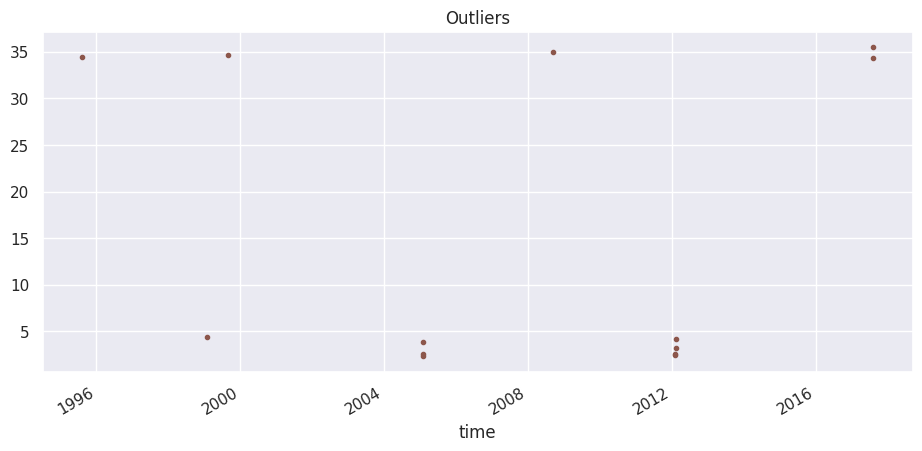

In [31]:
# Visualize temperature_2m_mean parameter outliers
weather_df.query('temperature_2m_mean < 5|temperature_2m_mean > 34' )['temperature_2m_mean'] \
    .plot(style='.',
          figsize=(10, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='time'>

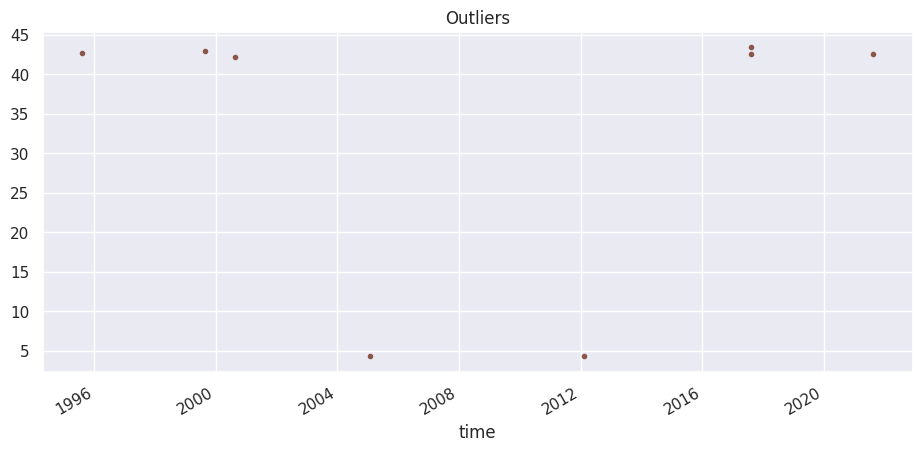

In [32]:
# Visualize temperature_2m_max parameter outliers
weather_df.query('temperature_2m_max < 5|temperature_2m_max > 42' )['temperature_2m_max'] \
    .plot(style='.',
          figsize=(10, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='time'>

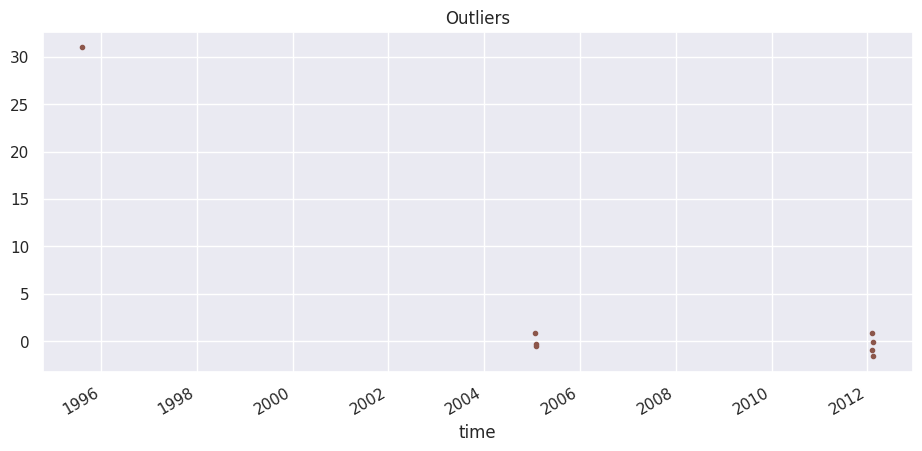

In [33]:
# Visualize temperature_2m_min parameter outliers
weather_df.query('temperature_2m_min < 1|temperature_2m_min > 30' )['temperature_2m_min'] \
    .plot(style='.',
          figsize=(10, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='time'>

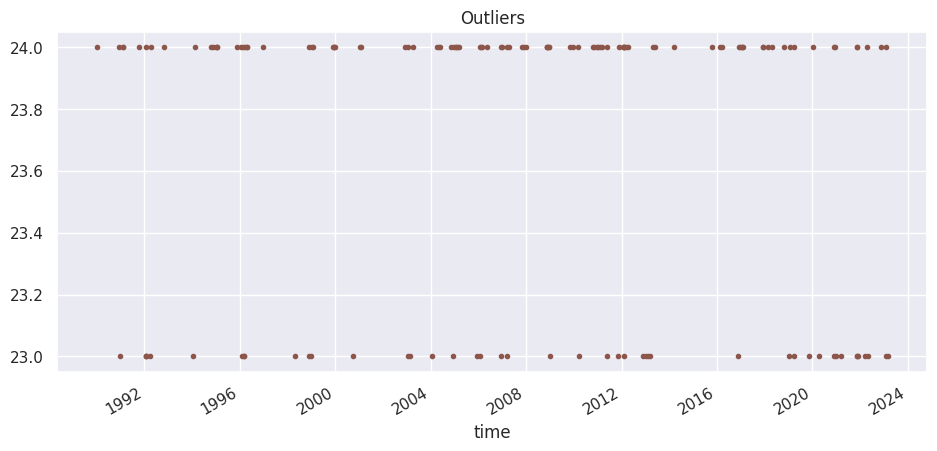

In [34]:
# Visualize precipitation_hours parameter outliers
weather_df.query('precipitation_hours > 22' )['precipitation_hours'] \
    .plot(style='.',
          figsize=(10, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='time'>

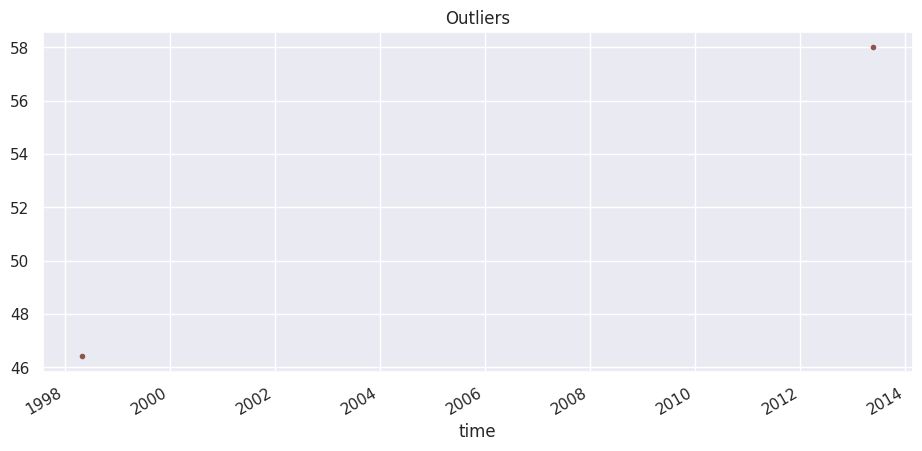

In [35]:
# Visualize precipitation_sum parameter outliers
weather_df.query('precipitation_sum > 45' )['precipitation_sum'] \
    .plot(style='.',
          figsize=(10, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='time'>

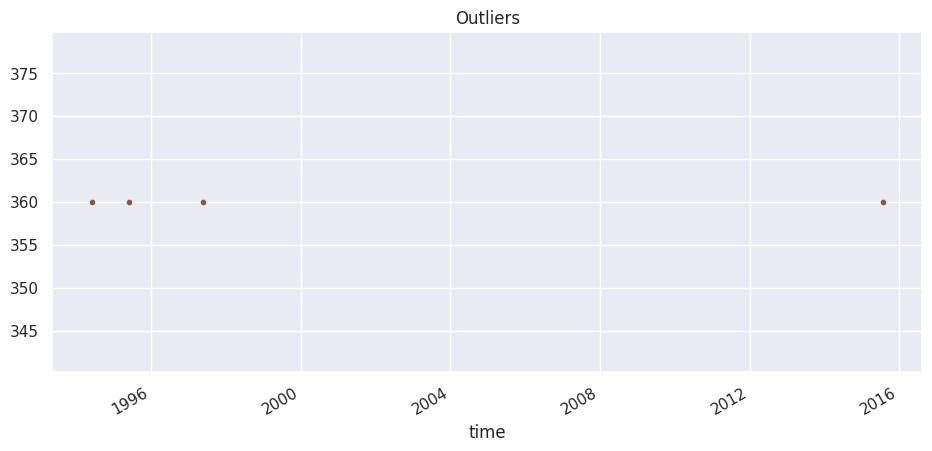

In [36]:
# Visualize winddirection_10m_dominant parameter outliers
weather_df.query('winddirection_10m_dominant > 359' )['winddirection_10m_dominant'] \
    .plot(style='.',
          figsize=(10, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='time'>

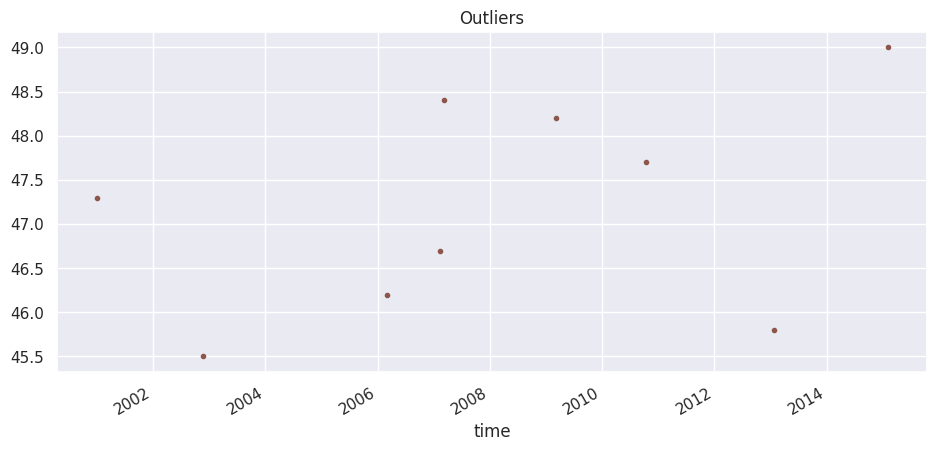

In [37]:
# Visualize windspeed_10m_max parameter outliers
weather_df.query('windspeed_10m_max < 5|windspeed_10m_max > 45' )['windspeed_10m_max'] \
    .plot(style='.',
          figsize=(10, 5),
          color=color_pal[5],
          title='Outliers')

# **Step 3 : Create target parameter DataFrame**

The open-meteo historical Weather data can be catogerised as timeseries. I decided to use this data to predict the future weatherstate for the coming year using machine learning algorithm XGBoost.

To allow machine learning modelisation, I aimed through this step to determine the ***Target parameters to be predicted*** and the features that can explain the best each target weather parameter.

So, I initially set all the weather parameter as target variable than used time series features (created based on time series index) and lags to perform an XGBoost algorithm using cross validation.

--------------------------
***Lag features***, also known as lag variables or lagged predictors, are variables derived from previous values of a time series or other sequential data. They capture the historical behavior of a variable and can be used as inputs in forecasting models or machine learning algorithms.

In time series analysis, a lag refers to the time delay between observations. Lag features are created by shifting the values of a variable forward or backward in time. Each lag represents the value of the variable at a previous time point relative to the current observation.

Lag features can provide valuable information for prediction and forecasting tasks. They can capture patterns, trends, seasonality, and dependencies in the data. By including lag features as predictors in a model, you can leverage the past behavior of the variable to make predictions about its future behavior.

In summary, lag features are historical values of a variable that are used as predictors to capture the temporal patterns and dependencies in the data for forecasting or prediction tasks.

----------------
I choosed MSE and R2 to evaluate the prediction models.
According to the validation metrics results obtained for each prediction model, I have determine the first parameter to be predicted using only time series and lags features.

The choosed parameters are :
* apparent_temperature_mean (R2 = 0.88) ;
* temperature_2m_mean (R2 = 0.84).

The winddirection_10m_dominant and windspeed_10m_max parameters will be exclude from the parameters to be predicted since they are  poorly explained by the other variables and the model validation involve low accurancy.

For the remaining parameters, I added other weather parameters as features according to the correlation indice (corr > 0.2) with the target parameter.

I have also process Somme additionnal data cleaning by removing the outliers.

## 1. Create target parameter DataFrame (including base features only)

In [38]:
drop_columns_dict = {'apparent_temperature_mean':
                    ['weathercode', 'temperature_2m_max', 'temperature_2m_min',
                    'temperature_2m_mean', 'sunrise', 'sunset', 'precipitation_sum', 'precipitation_hours',
                    'rain_sum', 'windspeed_10m_max', 'winddirection_10m_dominant'],
                    'temperature_2m_mean' :
                     ['weathercode', 'temperature_2m_max', 'temperature_2m_min',
                    'apparent_temperature_mean', 'sunrise', 'sunset','precipitation_sum', 'precipitation_hours',
                    'rain_sum', 'windspeed_10m_max', 'winddirection_10m_dominant'],
                     'temperature_2m_max':
                     ['weathercode', 'temperature_2m_min','sunrise', 'sunset', 'precipitation_sum', 'precipitation_hours',
                    'rain_sum','windspeed_10m_max', 'winddirection_10m_dominant'],
                     'temperature_2m_min' :
                     ['weathercode', 'temperature_2m_mean', 'sunrise', 'sunset','precipitation_sum', 'precipitation_hours',
                      'rain_sum','windspeed_10m_max', 'winddirection_10m_dominant'],
                     'precipitation_hours':
                     ['weathercode', 'temperature_2m_mean', 'sunrise', 'sunset','precipitation_sum', 'rain_sum',
                     'windspeed_10m_max', 'winddirection_10m_dominant'],
                     'precipitation_sum':
                     ['weathercode', 'temperature_2m_mean', 'sunrise', 'sunset', 'rain_sum','windspeed_10m_max',
                      'winddirection_10m_dominant'],
                     'winddirection_10m_dominant':
                      ['weathercode', 'sunrise', 'sunset', 'rain_sum', 'temperature_2m_mean', 'windspeed_10m_max'],
                      'windspeed_10m_max':
                     ['weathercode', 'sunrise', 'sunset','rain_sum']}

threshold = 0.2
parameters.remove('weathercode')

df_dict = {}
FEATURES_dict = {}
for parameter in parameters:
  FEATURES = create_basefeatures(parameter, drop_columns_dict[parameter],threshold, weather_df)
  FEATURES_dict[parameter] = FEATURES
  df = timeserie_df(FEATURES, weather_df)
  df = df.values
  df_dict[parameter] = df


In [39]:
apparent_temperature_mean_df = pd.DataFrame(df_dict['apparent_temperature_mean'], columns=FEATURES_dict['apparent_temperature_mean'],
                                            index=weather_df.index)
temperature_2m_mean_df = pd.DataFrame(df_dict['temperature_2m_mean'], columns=FEATURES_dict['temperature_2m_mean'],
                                      index=weather_df.index)
temperature_2m_max_df = pd.DataFrame(df_dict['temperature_2m_max'], columns=FEATURES_dict['temperature_2m_max'],
                                     index=weather_df.index)
temperature_2m_min_df = pd.DataFrame(df_dict['temperature_2m_min'], columns=FEATURES_dict['temperature_2m_min'],
                                     index=weather_df.index)
precipitation_sum_df = pd.DataFrame(df_dict['precipitation_sum'], columns=FEATURES_dict['precipitation_sum'],
                                    index=weather_df.index)
precipitation_hours_df = pd.DataFrame(df_dict['precipitation_hours'], columns=FEATURES_dict['precipitation_hours'],
                                      index=weather_df.index)
winddirection_10m_dominant_df = pd.DataFrame(df_dict['winddirection_10m_dominant'], columns=FEATURES_dict['winddirection_10m_dominant'],
                                             index=weather_df.index)
windspeed_10m_max_df = pd.DataFrame(df_dict['windspeed_10m_max'], columns=FEATURES_dict['windspeed_10m_max'],
                                    index=weather_df.index)

In [40]:
# Create base_features list for 'weathercode' parameter
columns_to_drop2 = ['temperature_2m_mean', 'sunrise', 'sunset',
       'rain_sum', 'windspeed_10m_max', 'winddirection_10m_dominant']
threshold = 0.18
weathercode_TARGET = 'weathercode'
weathercode_TARGET_pred = f'{weathercode_TARGET}_pred'
weathercode_FEATURES = create_basefeatures(weathercode_TARGET, columns_to_drop2,threshold, weather_df)
# Create TARGET dataframe (with base_features)
weathercode_df = timeserie_df(weathercode_FEATURES, weather_df)

## 2. Remove outliers

Outliers can have an impact on the performance and accuracy of the XGBoost algorithm, as they can affect the training process and the resulting model.

In [41]:
apparent_temperature_mean_df = apparent_temperature_mean_df.query('apparent_temperature_mean > 1|apparent_temperature_mean < 35').copy()
temperature_2m_mean_df = temperature_2m_mean_df.query('temperature_2m_mean > 5|temperature_2m_mean < 34').copy()
temperature_2m_max_df = temperature_2m_max_df.query('temperature_2m_max > 5|temperature_2m_max < 42').copy()
temperature_2m_min_df = temperature_2m_min_df.query('temperature_2m_min > 1|temperature_2m_min < 30').copy()
precipitation_sum_df = precipitation_sum_df.query('precipitation_sum < 45').copy()
winddirection_10m_dominant_df = winddirection_10m_dominant_df.query('winddirection_10m_dominant < 359').copy()
windspeed_10m_max_df = windspeed_10m_max_df.query('windspeed_10m_max > 5|windspeed_10m_max < 45').copy()

## 3. Create and add temporel and lags features

In [42]:
apparent_temperature_mean_df = create_features(apparent_temperature_mean_df)
apparent_temperature_mean_df = add_lags(apparent_temperature_mean_df, 'apparent_temperature_mean')

temperature_2m_mean_df = create_features(temperature_2m_mean_df)
temperature_2m_mean_df = add_lags(temperature_2m_mean_df, 'temperature_2m_mean')

temperature_2m_max_df = create_features(temperature_2m_max_df)
temperature_2m_max_df = add_lags(temperature_2m_max_df, 'temperature_2m_max')

temperature_2m_min_df = create_features(temperature_2m_min_df)
temperature_2m_min_df = add_lags(temperature_2m_min_df, 'temperature_2m_min')

precipitation_hours_df = create_features(precipitation_hours_df)
precipitation_hours_df = add_lags(precipitation_hours_df, 'precipitation_hours')

precipitation_sum_df = create_features(precipitation_sum_df)
precipitation_sum_df = add_lags(precipitation_sum_df, 'precipitation_sum')

winddirection_10m_dominant_df = create_features(winddirection_10m_dominant_df)
winddirection_10m_dominant_df = add_lags(winddirection_10m_dominant_df, 'winddirection_10m_dominant')

windspeed_10m_max_df = create_features(windspeed_10m_max_df)
windspeed_10m_max_df = add_lags(windspeed_10m_max_df, 'windspeed_10m_max')

weathercode_df = create_features(weathercode_df)
weathercode_df = add_lags(weathercode_df, 'weathercode')

In [43]:
apparent_temperature_mean_FEATURES_Added = list(apparent_temperature_mean_df.columns)
apparent_temperature_mean_FEATURES_Added.remove('apparent_temperature_mean')

temperature_2m_mean_FEATURES_Added = list(temperature_2m_mean_df.columns)
temperature_2m_mean_FEATURES_Added.remove('temperature_2m_mean')

temperature_2m_max_FEATURES_Added = list(temperature_2m_max_df.columns)
temperature_2m_max_FEATURES_Added.remove('temperature_2m_max')

temperature_2m_min_FEATURES_Added = list(temperature_2m_min_df.columns)
temperature_2m_min_FEATURES_Added.remove('temperature_2m_min')

precipitation_hours_FEATURES_Added = list(precipitation_hours_df.columns)
precipitation_hours_FEATURES_Added.remove('precipitation_hours')

precipitation_sum_FEATURES_Added = list(precipitation_sum_df.columns)
precipitation_sum_FEATURES_Added.remove('precipitation_sum')

winddirection_10m_dominant_FEATURES_Added = list(winddirection_10m_dominant_df.columns)
winddirection_10m_dominant_FEATURES_Added.remove('winddirection_10m_dominant')

windspeed_10m_max_FEATURES_Added = list(windspeed_10m_max_df.columns)
windspeed_10m_max_FEATURES_Added.remove('windspeed_10m_max')

weathercode_FEATURES_Added = list(weathercode_df.columns)
weathercode_FEATURES_Added.remove('weathercode')

# **Step 4 : split data (using cross validation) & Create, fit, train and evaluate models prediction**

## 1. Explain modelisation choices and process


***Gradient boosting*** refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.

Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm. This gives the technique its name, “gradient boosting,” as the loss gradient is minimized as the model is fit, much like a neural network.

It is designed to be both computationally efficient (e.g. fast to execute) and highly effective, perhaps more effective than other open-source implementations.

The two main reasons to use XGBoost are execution speed and model performance.

XGBoost dominates structured or tabular datasets on classification and regression predictive modeling problems. The evidence is that it is the go-to algorithm for competition winners on the Kaggle competitive data science platform.

 [For more information check the Source link (click)](https://machinelearningmastery.com/xgboost-for-regression/)
-----------------

***Cross-validation ***is a crucial technique in evaluating and selecting models for time series data. It helps to assess the performance and generalization ability of time series models by simulating how they would perform on unseen data. Here are the key reasons why cross-validation is important in time series analysis:


*   Handling Temporal Dependencies ;
*   Model Selection ;
*   Parameter Tuning
*   Detecting Overfitting ;
*   Robustness Assessment ;
*   Out-of-Sample Evaluation.

By employing cross-validation techniques in time series analysis, we can make more informed decisions about model selection, parameter tuning, and robustness assessment. It helps in building reliable and accurate time series models that can effectively capture the underlying patterns and make accurate predictions in real-world scenarios.
Source : ChatGPT

-------------------

***NB*** : Since the forecast horizon is the length of time into the future for which forecasts are to be prepared, we assume that the forcasting horizon is one year. So we choose the test_size data to be equal to the number of days in one year (365*1).

## 2. Split data (using cross validation) & Create, fit, train prediction models

In [44]:
# 1. First parameter : apparent_temperature_mean
estimators1 = 700
model_result1 = model_function(apparent_temperature_mean_df, apparent_temperature_mean_FEATURES_Added, 'apparent_temperature_mean', estimators1)

[16:13:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.54133	validation_1-rmse:19.00683
[100]	validation_0-rmse:7.40029	validation_1-rmse:7.46801
[200]	validation_0-rmse:3.78629	validation_1-rmse:3.60536
[300]	validation_0-rmse:2.89469	validation_1-rmse:2.57965
[400]	validation_0-rmse:2.70184	validation_1-rmse:2.33040
[494]	validation_0-rmse:2.64696	validation_1-rmse:2.32754
[16:13:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.55649	validation_1-rmse:19.82989
[100]	validation_0-rmse:7.39871	validation_1-rmse:8.33296
[200]	validation_0-rmse:3.77684	validation_1-rmse:4.42724
[300]	validation_0-rmse:2.88283	validation_1-rmse:3.22040
[400]	validation_0-rmse:2.69014	validation_1-rmse:2.87444
[500]	validation_0-rmse:2.63279	validation_1-rmse:2.76443
[600]	validation_0-rmse:2.59631	validation_1-rmse:2.72671
[699]	va

In [45]:
# 2. Second parameter : 'temperature_2m_mean'
estimator2 = 825
model_result2 = model_function(temperature_2m_mean_df, temperature_2m_mean_FEATURES_Added, 'temperature_2m_mean', estimator2)

[16:13:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.44303	validation_1-rmse:18.64185
[100]	validation_0-rmse:7.17861	validation_1-rmse:7.08483
[200]	validation_0-rmse:3.41329	validation_1-rmse:3.09231
[300]	validation_0-rmse:2.44247	validation_1-rmse:1.98771
[400]	validation_0-rmse:2.24121	validation_1-rmse:1.78589
[479]	validation_0-rmse:2.19714	validation_1-rmse:1.79415
[16:13:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.44915	validation_1-rmse:19.66663
[100]	validation_0-rmse:7.17424	validation_1-rmse:8.11027
[200]	validation_0-rmse:3.40154	validation_1-rmse:4.14791
[300]	validation_0-rmse:2.42666	validation_1-rmse:2.89790
[400]	validation_0-rmse:2.22444	validation_1-rmse:2.55127
[500]	validation_0-rmse:2.17242	validation_1-rmse:2.46927
[600]	validation_0-rmse:2.14101	validation_1-rmse:2.44294
[700]	va

In [46]:
# 3. Third parameter : 'temperature_2m_max'
estimators3 = 890
model_result3 = model_function(temperature_2m_max_df, temperature_2m_max_FEATURES_Added, 'temperature_2m_max', estimators3)

[16:14:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:23.49961	validation_1-rmse:23.72805
[100]	validation_0-rmse:8.74141	validation_1-rmse:8.79511
[200]	validation_0-rmse:3.49659	validation_1-rmse:3.51467
[300]	validation_0-rmse:1.86566	validation_1-rmse:1.90243
[400]	validation_0-rmse:1.49636	validation_1-rmse:1.56172
[500]	validation_0-rmse:1.42358	validation_1-rmse:1.49891
[600]	validation_0-rmse:1.40361	validation_1-rmse:1.48421
[700]	validation_0-rmse:1.39516	validation_1-rmse:1.48063
[741]	validation_0-rmse:1.39237	validation_1-rmse:1.48218
[16:14:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:23.50673	validation_1-rmse:24.89010
[100]	validation_0-rmse:8.74388	validation_1-rmse:9.31057
[200]	validation_0-rmse:3.49788	validation_1-rmse:3.74325
[300]	validation_0-rmse:1.86719	validation_1-rmse:1.99469
[400]	va

In [47]:
# 4. Forth parameter : 'temperature_2m_min'
estimators4 = 1700
model_result4 = model_function(temperature_2m_min_df, temperature_2m_min_FEATURES_Added, 'temperature_2m_min', estimators4)

[16:14:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13.90090	validation_1-rmse:14.06277
[100]	validation_0-rmse:5.33951	validation_1-rmse:5.30439
[200]	validation_0-rmse:2.47219	validation_1-rmse:2.38129
[300]	validation_0-rmse:1.71007	validation_1-rmse:1.62293
[400]	validation_0-rmse:1.54556	validation_1-rmse:1.48283
[500]	validation_0-rmse:1.49669	validation_1-rmse:1.45124
[600]	validation_0-rmse:1.47448	validation_1-rmse:1.43697
[700]	validation_0-rmse:1.45933	validation_1-rmse:1.42857
[800]	validation_0-rmse:1.44739	validation_1-rmse:1.42391
[900]	validation_0-rmse:1.43526	validation_1-rmse:1.41791
[1000]	validation_0-rmse:1.42357	validation_1-rmse:1.41180
[1100]	validation_0-rmse:1.41318	validation_1-rmse:1.40538
[1200]	validation_0-rmse:1.40462	validation_1-rmse:1.39967
[1300]	validation_0-rmse:1.39709	validation_1-rmse:1.39519
[1400]	validation_0-rmse:1.39055	validation_1-rmse:1.39153
[1500]

In [48]:
# 5. Fiveth parameter : 'precipitation_hours'
estimators5= 1000
model_result5 = model_function(precipitation_hours_df, precipitation_hours_FEATURES_Added, 'precipitation_hours', estimators5)

[16:15:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.73344	validation_1-rmse:5.57889
[100]	validation_0-rmse:4.05506	validation_1-rmse:4.16349
[200]	validation_0-rmse:3.59199	validation_1-rmse:3.77633
[300]	validation_0-rmse:3.43251	validation_1-rmse:3.64317
[400]	validation_0-rmse:3.33684	validation_1-rmse:3.56859
[500]	validation_0-rmse:3.26714	validation_1-rmse:3.50833
[600]	validation_0-rmse:3.21197	validation_1-rmse:3.44524
[700]	validation_0-rmse:3.17015	validation_1-rmse:3.40560
[800]	validation_0-rmse:3.13676	validation_1-rmse:3.36980
[900]	validation_0-rmse:3.10906	validation_1-rmse:3.35346
[999]	validation_0-rmse:3.08620	validation_1-rmse:3.33939
[16:15:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.72828	validation_1-rmse:4.59902
[100]	validation_0-rmse:4.05777	validation_1-rmse:3.66361
[200]	valida

In [49]:
# 6. Sixth parameter : 'precipitation_sum'
estimators6 = 280
model_result6 = model_function(precipitation_sum_df, precipitation_sum_FEATURES_Added, 'precipitation_sum', estimators6)

[16:15:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.43056	validation_1-rmse:4.16523
[100]	validation_0-rmse:2.54500	validation_1-rmse:2.23188
[200]	validation_0-rmse:2.10417	validation_1-rmse:1.85961
[279]	validation_0-rmse:2.00091	validation_1-rmse:1.84698
[16:15:53] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.42180	validation_1-rmse:3.31713
[100]	validation_0-rmse:2.53803	validation_1-rmse:2.12948
[200]	validation_0-rmse:2.10026	validation_1-rmse:1.94394
[279]	validation_0-rmse:2.00399	validation_1-rmse:1.93377
[16:15:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.39007	validation_1-rmse:3.46544
[100]	validation_0-rmse:2.52819	validation_1-rmse:1.81018
[200]	validation_0-rmse:2.09825	validation_1-rmse:1.47250
[279]	valid

In [50]:
# 7. Seventh parameter : 'winddirection_10m_dominant'
estimators7 = 500
model_result7 = model_function(winddirection_10m_dominant_df, winddirection_10m_dominant_FEATURES_Added, 'winddirection_10m_dominant', estimators7)

[16:16:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:194.75513	validation_1-rmse:198.07741
[100]	validation_0-rmse:112.91509	validation_1-rmse:119.11667
[200]	validation_0-rmse:96.21842	validation_1-rmse:102.25868
[300]	validation_0-rmse:93.22879	validation_1-rmse:98.89788
[400]	validation_0-rmse:92.48456	validation_1-rmse:97.98423
[499]	validation_0-rmse:92.10414	validation_1-rmse:97.68160
[16:16:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:194.84546	validation_1-rmse:202.25638
[100]	validation_0-rmse:113.05743	validation_1-rmse:122.77047
[200]	validation_0-rmse:96.38428	validation_1-rmse:104.50040
[300]	validation_0-rmse:93.42410	validation_1-rmse:100.66423
[400]	validation_0-rmse:92.69542	validation_1-rmse:99.79461
[489]	validation_0-rmse:92.35938	validation_1-rmse:99.84871
[16:16:06] WARNING: ../src/objectiv

In [51]:
# 8. Eighth parameter : 'windspeed_10m_max'
estimators8 = 450
model_result8 = model_function(windspeed_10m_max_df, windspeed_10m_max_FEATURES_Added, 'windspeed_10m_max', estimators8)

[16:16:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.17042	validation_1-rmse:17.63945
[100]	validation_0-rmse:8.48848	validation_1-rmse:8.01194
[200]	validation_0-rmse:6.07401	validation_1-rmse:5.62317
[300]	validation_0-rmse:5.64271	validation_1-rmse:5.28894
[400]	validation_0-rmse:5.55717	validation_1-rmse:5.26919
[414]	validation_0-rmse:5.55157	validation_1-rmse:5.27393
[16:16:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.15280	validation_1-rmse:19.31725
[100]	validation_0-rmse:8.47735	validation_1-rmse:9.91187
[200]	validation_0-rmse:6.06372	validation_1-rmse:7.34542
[300]	validation_0-rmse:5.63076	validation_1-rmse:6.76224
[400]	validation_0-rmse:5.54554	validation_1-rmse:6.61681
[449]	validation_0-rmse:5.52669	validation_1-rmse:6.59146
[16:16:23] WARNING: ../src/objective/regression_obj.cu:213: reg:li

In [52]:
# 9. Nineth parameter : 'weathercode'
estimator9 = 800
model_result9 = model_function(weathercode_df, weathercode_FEATURES_Added, 'weathercode', estimator9)

[16:16:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.08349	validation_1-rmse:31.59554
[100]	validation_0-rmse:11.84969	validation_1-rmse:11.59231
[200]	validation_0-rmse:4.56455	validation_1-rmse:4.37076
[300]	validation_0-rmse:2.13555	validation_1-rmse:1.93360
[400]	validation_0-rmse:1.49299	validation_1-rmse:1.31132
[500]	validation_0-rmse:1.33926	validation_1-rmse:1.19579
[600]	validation_0-rmse:1.27652	validation_1-rmse:1.15305
[700]	validation_0-rmse:1.24568	validation_1-rmse:1.14551
[799]	validation_0-rmse:1.22299	validation_1-rmse:1.14043
[16:16:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.06708	validation_1-rmse:30.91388
[100]	validation_0-rmse:11.84260	validation_1-rmse:11.47643
[200]	validation_0-rmse:4.56009	validation_1-rmse:4.44787
[300]	validation_0-rmse:2.13181	validation_1-rmse:2.06511
[400

## 3. Evaluate prediction model

In [53]:
# 1. First parameter : apparent_temperature_mean
evaluation(model_result1[1], model_result1[3])

MSEs across folds 2.6931
Fold mses:[2.3082312434258148, 2.7073664785839475, 2.8110310279810693, 2.583315751705465, 3.0555136155364115]
R2s across folds 0.8761
Fold R2s:[0.9125242820845572, 0.8701520325703189, 0.8531426248631218, 0.9017040844470533, 0.8428372436507433]


In [54]:
# 2. Second parameter : 'temperature_2m_mean'
evaluation(model_result2[1], model_result2[3])

MSEs across folds 2.4042
Fold mses:[1.7718354335945778, 2.4190238745439774, 2.5553054518719853, 2.418040571164267, 2.8566819212335983]
R2s across folds 0.8432
Fold R2s:[0.9124244732642588, 0.8355114267426564, 0.8123197572632403, 0.868647539155124, 0.786978071403624]


In [55]:
# 3. Third parameter : 'temperature_2m_max'
evaluation(model_result3[1], model_result3[3])

MSEs across folds 1.5079
Fold mses:[1.4805617209847795, 1.5238799162334224, 1.4956404471092786, 1.467343870089018, 1.5718558215955096]
R2s across folds 0.9528
Fold R2s:[0.9510809022875907, 0.9481676819130741, 0.9516770951980333, 0.9629042161886308, 0.9502797980140496]


In [56]:
# 4. Forth parameter : 'temperature_2m_min'
evaluation(model_result4[1], model_result4[3])

MSEs across folds 1.5180
Fold mses:[1.3768807164054078, 1.5716724477806545, 1.627038270179142, 1.527602104444977, 1.4869736925910495]
R2s across folds 0.9235
Fold R2s:[0.9374822723160943, 0.9170088763425162, 0.9005079012173696, 0.9338122867830203, 0.9289133657580878]


In [57]:
# 5. Fiveth parameter : 'precipitation_hours'
evaluation(model_result5[1], model_result5[3])

MSEs across folds 3.3873
Fold mses:[3.3390473475947027, 3.2025403440947797, 3.1758108682790187, 3.6419289903437693, 3.5774160692812753]
R2s across folds 0.5686
Fold R2s:[0.5889017640679782, 0.4525708354455239, 0.549153610940711, 0.644535833282233, 0.6078858386740086]


In [58]:
# 6. Sixth parameter : 'precipitation_sum'
evaluation(model_result6[1], model_result6[3])

MSEs across folds 1.7992
Fold mses:[1.8323121709449945, 1.9337662197887606, 1.4414443350467867, 2.2497320191058487, 1.5386781222576553]
R2s across folds 0.7587
Fold R2s:[0.7981788350691152, 0.6517359490760022, 0.8217594735367142, 0.7733561121616244, 0.7483525593468321]


In [59]:
# 7. Seventh parameter : 'winddirection_10m_dominant'
evaluation(model_result7[1], model_result7[3])

MSEs across folds 97.8876
Fold mses:[97.67980927701053, 99.73367449810685, 93.64098339448202, 104.75354693654177, 93.6300090063894]
R2s across folds 0.1224
Fold R2s:[0.13483369130627498, 0.060577642690370914, 0.1472335739220616, 0.09912950830503875, 0.17002943323067388]


In [60]:
# 8. Eighth parameter : 'windspeed_10m_max'
evaluation(model_result8[1], model_result8[3])

MSEs across folds 5.8583
Fold mses:[5.264453659530753, 6.5914621828742685, 5.77730016569128, 5.805041338682624, 5.853066660810549]
R2s across folds 0.1272
Fold R2s:[0.2104903357451151, 0.06382279061322371, 0.16752726343644464, 0.11820838488486762, 0.07579350979290789]


In [61]:
# 9. Nineth parameter : 'weathercode'
evaluation(model_result9[1], model_result9[3])

MSEs across folds 1.2577
Fold mses:[1.1400738923718217, 1.1261520970714225, 1.2657927161026152, 1.370954089151009, 1.3853486181586943]
R2s across folds 0.9975
Fold R2s:[0.9980059295993355, 0.9979983991810893, 0.9974677012484107, 0.9970960366847916, 0.9970671644401751]


In [62]:
Pred_parameters = ['apparent_temperature_mean', 'temperature_2m_mean', 'temperature_2m_max',
                   'temperature_2m_min', 'precipitation_hours', 'precipitation_sum', 'winddirection_10m_dominant',
                   'windspeed_10m_max', 'weathercode' ]
R2_dict = {}
R2_list = [round(np.mean(model_result1[3]), 2), round(np.mean(model_result2[3]), 2), round(np.mean(model_result3[3]), 2),
           round(np.mean(model_result4[3]), 2), round(np.mean(model_result5[3]), 2), round(np.mean(model_result6[3]), 2),
           round(np.mean(model_result7[3]), 2), round(np.mean(model_result8[3]), 2), round(np.mean(model_result9[3]), 2)]
for key, value in zip(Pred_parameters, R2_list):
    R2_dict[key] = value
print(f'The R2 for each predictionmodel : \n {R2_dict}')

The R2 for each predictionmodel : 
 {'apparent_temperature_mean': 0.88, 'temperature_2m_mean': 0.84, 'temperature_2m_max': 0.95, 'temperature_2m_min': 0.92, 'precipitation_hours': 0.57, 'precipitation_sum': 0.76, 'winddirection_10m_dominant': 0.12, 'windspeed_10m_max': 0.13, 'weathercode': 1.0}


In [63]:
MSE_dict = {}
MSE_list = [round(np.mean(model_result1[1]), 2), round(np.mean(model_result2[1]), 2), round(np.mean(model_result3[1]), 2),
            round(np.mean(model_result4[1]), 2), round(np.mean(model_result5[1]), 2), round(np.mean(model_result6[1]), 2),
            round(np.mean(model_result7[1]), 2), round(np.mean(model_result8[1]), 2), round(np.mean(model_result9[1]), 2)]
for key, value in zip(Pred_parameters, MSE_list):
  MSE_dict[key] = value
print(f'The MSE for each predictionmodel : \n {MSE_dict}')

The MSE for each predictionmodel : 
 {'apparent_temperature_mean': 2.69, 'temperature_2m_mean': 2.4, 'temperature_2m_max': 1.51, 'temperature_2m_min': 1.52, 'precipitation_hours': 3.39, 'precipitation_sum': 1.8, 'winddirection_10m_dominant': 97.89, 'windspeed_10m_max': 5.86, 'weathercode': 1.26}


## 4. Visualize predicted values Vs real values

[16:17:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.70404
[100]	validation_0-rmse:7.45205
[200]	validation_0-rmse:3.80350
[300]	validation_0-rmse:2.90682
[400]	validation_0-rmse:2.70753
[500]	validation_0-rmse:2.65370
[600]	validation_0-rmse:2.61756
[699]	validation_0-rmse:2.58859


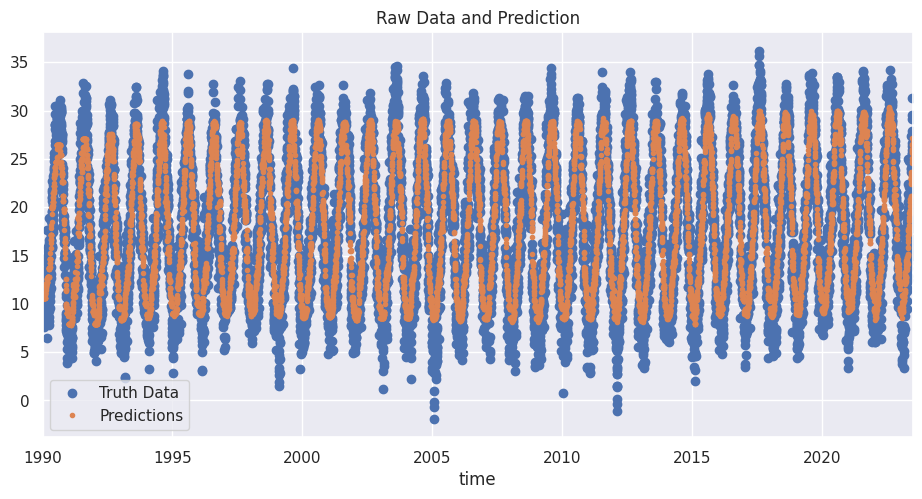

In [64]:
# 1. First parameter : apparent_temperature_mean
# a. Retrain on all data and save it
trained_model = train_all(apparent_temperature_mean_df, apparent_temperature_mean_FEATURES_Added, 'apparent_temperature_mean', estimators1)
# b. Use saved model to create TARGET_pred values on historical data
apparent_temperature_mean_df['apparent_temperature_mean_pred'] = param_pred(apparent_temperature_mean_df, 'apparent_temperature_mean_pred',
                                                                   'apparent_temperature_mean', apparent_temperature_mean_FEATURES_Added )
# c. Create TARGET & TARGET_pred DtataFrame
apparent_temperature_mean_target_df = create_target_df(apparent_temperature_mean_df, 'apparent_temperature_mean',
                                                       'apparent_temperature_mean_pred')
# d. Visualize TARGET Vs TARGET_Pred
data_viz(apparent_temperature_mean_target_df, 'apparent_temperature_mean', 'apparent_temperature_mean_pred')

[16:17:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.59840
[100]	validation_0-rmse:7.23493
[200]	validation_0-rmse:3.44749
[300]	validation_0-rmse:2.47448
[400]	validation_0-rmse:2.27211
[500]	validation_0-rmse:2.21484
[600]	validation_0-rmse:2.18758
[700]	validation_0-rmse:2.16318
[800]	validation_0-rmse:2.14690
[824]	validation_0-rmse:2.14389


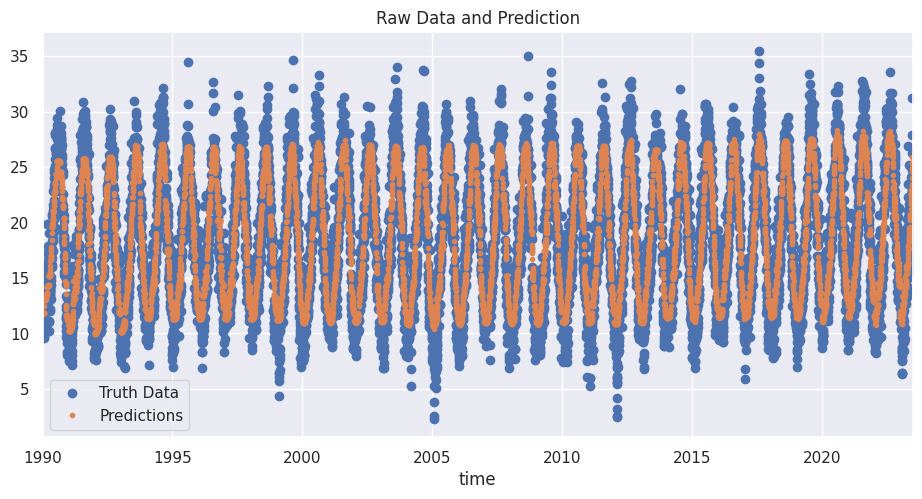

In [65]:
# 2. Second parameter : 'temperature_2m_mean'
# a. Retrain on all data and save it
trained_model = train_all(temperature_2m_mean_df, temperature_2m_mean_FEATURES_Added, 'temperature_2m_mean', estimator2)
# b. Use saved model to create TARGET_pred values on historical data
temperature_2m_mean_df['temperature_2m_mean_pred'] = param_pred(temperature_2m_mean_df, 'temperature_2m_mean_pred',
                                                                   'temperature_2m_mean', temperature_2m_mean_FEATURES_Added )
# c. Create TARGET & TARGET_pred DtataFrame
temperature_2m_mean_target_df = create_target_df(temperature_2m_mean_df, 'temperature_2m_mean',
                                                       'temperature_2m_mean_pred')
# d. Visualize TARGET Vs TARGET_Pred
data_viz(temperature_2m_mean_target_df, 'temperature_2m_mean', 'temperature_2m_mean_pred')

[16:17:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:23.68537
[100]	validation_0-rmse:8.80928
[200]	validation_0-rmse:3.52366
[300]	validation_0-rmse:1.88088
[400]	validation_0-rmse:1.50954
[500]	validation_0-rmse:1.43716
[600]	validation_0-rmse:1.41804
[700]	validation_0-rmse:1.40945
[800]	validation_0-rmse:1.40161
[889]	validation_0-rmse:1.39515


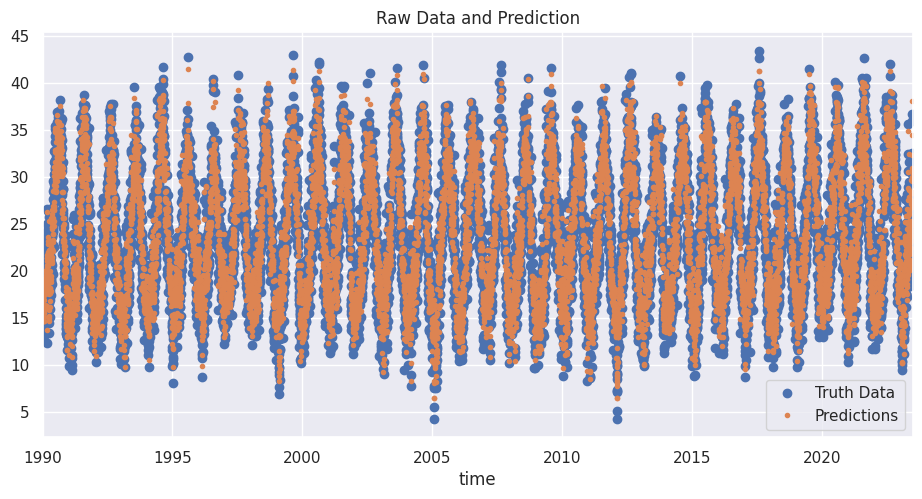

In [66]:
# 3. Third parameter : 'temperature_2m_max'
# a. Retrain on all data and save it
trained_model = train_all(temperature_2m_max_df, temperature_2m_max_FEATURES_Added, 'temperature_2m_max', estimators3)
# b. Use saved model to create TARGET_pred values on historical data
temperature_2m_max_df['temperature_2m_max_pred'] = param_pred(temperature_2m_max_df, 'temperature_2m_max_pred',
                                                                   'temperature_2m_max', temperature_2m_max_FEATURES_Added )
# c. Create TARGET & TARGET_pred DtataFrame
temperature_2m_max_target_df = create_target_df(temperature_2m_max_df, 'temperature_2m_max',
                                                       'temperature_2m_max_pred')
# d. Visualize TARGET Vs TARGET_Pred
data_viz(temperature_2m_max_target_df, 'temperature_2m_max', 'temperature_2m_max_pred')


[16:17:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14.02880
[100]	validation_0-rmse:5.38556
[200]	validation_0-rmse:2.48923
[300]	validation_0-rmse:1.72100
[400]	validation_0-rmse:1.55636
[500]	validation_0-rmse:1.50843
[600]	validation_0-rmse:1.48712
[700]	validation_0-rmse:1.47198
[800]	validation_0-rmse:1.45837
[900]	validation_0-rmse:1.44699
[1000]	validation_0-rmse:1.43602
[1100]	validation_0-rmse:1.42635
[1200]	validation_0-rmse:1.41806
[1300]	validation_0-rmse:1.41025
[1400]	validation_0-rmse:1.40230
[1500]	validation_0-rmse:1.39543
[1600]	validation_0-rmse:1.38939
[1699]	validation_0-rmse:1.38373


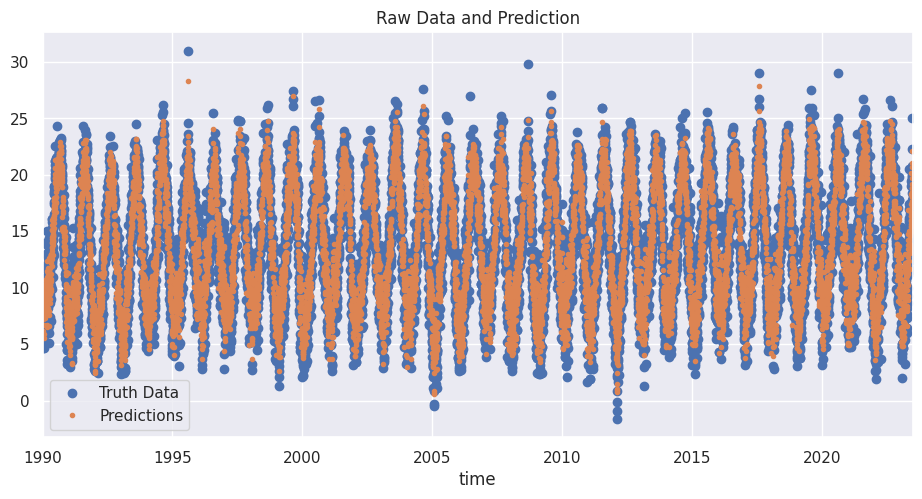

In [67]:
# 4. Forth parameter : 'temperature_2m_min'
# a. Retrain on all data and save it
trained_model = train_all(temperature_2m_min_df, temperature_2m_min_FEATURES_Added, 'temperature_2m_min', estimators4)
# b. Use saved model to create TARGET_pred values on historical data
temperature_2m_min_df['temperature_2m_min_pred'] = param_pred(temperature_2m_min_df, 'temperature_2m_min_pred',
                                                                   'temperature_2m_min', temperature_2m_min_FEATURES_Added )
# c. Create TARGET & TARGET_pred DtataFrame
temperature_2m_min_target_df = create_target_df(temperature_2m_min_df, 'temperature_2m_min',
                                                       'temperature_2m_min_pred')
# d. Visualize TARGET Vs TARGET_Pred
data_viz(temperature_2m_min_target_df, 'temperature_2m_min', 'temperature_2m_min_pred')

[16:17:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.72458
[100]	validation_0-rmse:4.06898
[200]	validation_0-rmse:3.61295
[300]	validation_0-rmse:3.45900
[400]	validation_0-rmse:3.36315
[500]	validation_0-rmse:3.29361
[600]	validation_0-rmse:3.23891
[700]	validation_0-rmse:3.19772
[800]	validation_0-rmse:3.16347
[900]	validation_0-rmse:3.13535
[999]	validation_0-rmse:3.11135


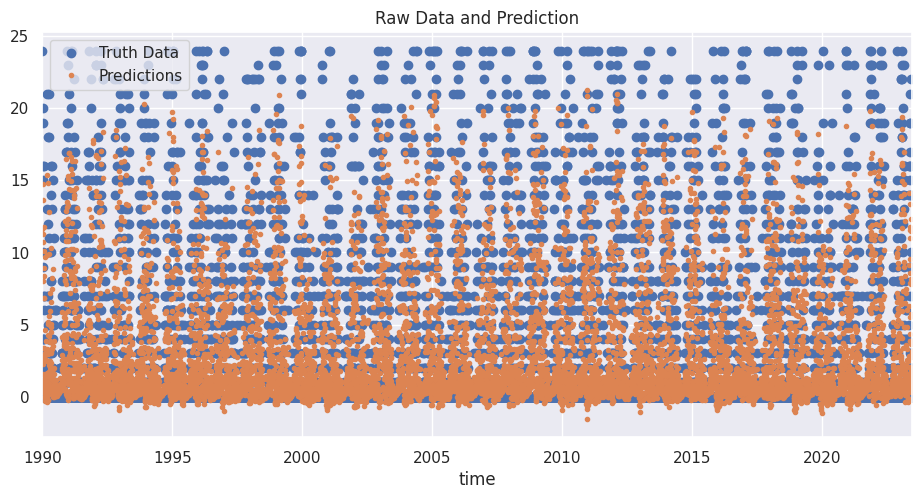

In [68]:
# 5. Fiveth parameter : 'precipitation_hours'
# a. Retrain on all data and save it
trained_model = train_all(precipitation_hours_df, precipitation_hours_FEATURES_Added, 'precipitation_hours', estimators5)
# b. Use saved model to create TARGET_pred values on historical data
precipitation_hours_df['precipitation_hours_pred'] = param_pred(precipitation_hours_df, 'precipitation_hours_pred',
                                                                   'precipitation_hours', precipitation_hours_FEATURES_Added )
# c. Create TARGET & TARGET_pred DtataFrame
precipitation_hours_target_df = create_target_df(precipitation_hours_df, 'precipitation_hours',
                                                       'precipitation_hours_pred')
# d. Visualize TARGET Vs TARGET_Pred
data_viz(precipitation_hours_target_df, 'precipitation_hours', 'precipitation_hours_pred')

[16:18:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.34766
[100]	validation_0-rmse:2.51240
[200]	validation_0-rmse:2.09447
[279]	validation_0-rmse:1.99788


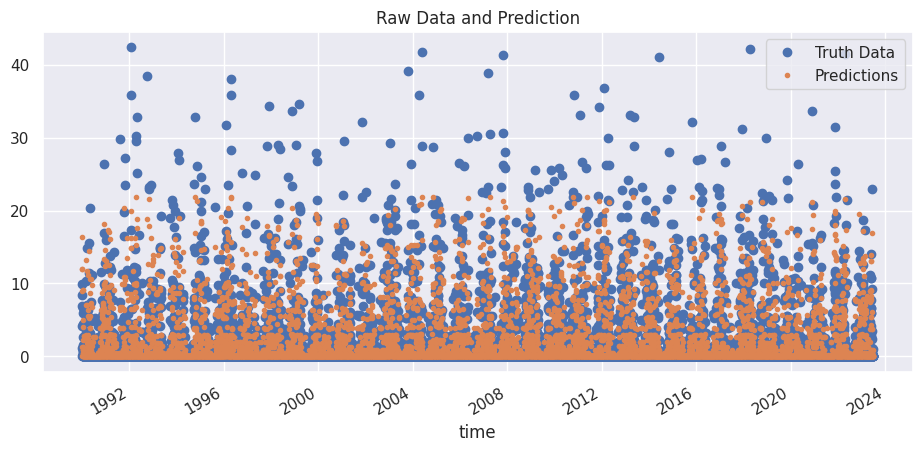

In [69]:
# 6. Sixth parameter : 'precipitation_sum'
# a. Retrain on all data and save it
trained_model = train_all(precipitation_sum_df, precipitation_sum_FEATURES_Added, 'precipitation_sum', estimators6)
# b. Use saved model to create TARGET_pred values on historical data
precipitation_sum_df['precipitation_sum_pred'] = param_pred(precipitation_sum_df, 'precipitation_sum_pred',
                                                                   'precipitation_sum', precipitation_sum_FEATURES_Added )
# c. Create TARGET & TARGET_pred DtataFrame
precipitation_sum_target_df = create_target_df(precipitation_sum_df, 'precipitation_sum',
                                                       'precipitation_sum_pred')
# d. Visualize TARGET Vs TARGET_Pred
data_viz(precipitation_sum_target_df, 'precipitation_sum', 'precipitation_sum_pred')

[16:18:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:31.95363
[100]	validation_0-rmse:11.79880
[200]	validation_0-rmse:4.54219
[300]	validation_0-rmse:2.12364
[400]	validation_0-rmse:1.48543
[500]	validation_0-rmse:1.33401
[600]	validation_0-rmse:1.27590
[700]	validation_0-rmse:1.24827
[799]	validation_0-rmse:1.22710


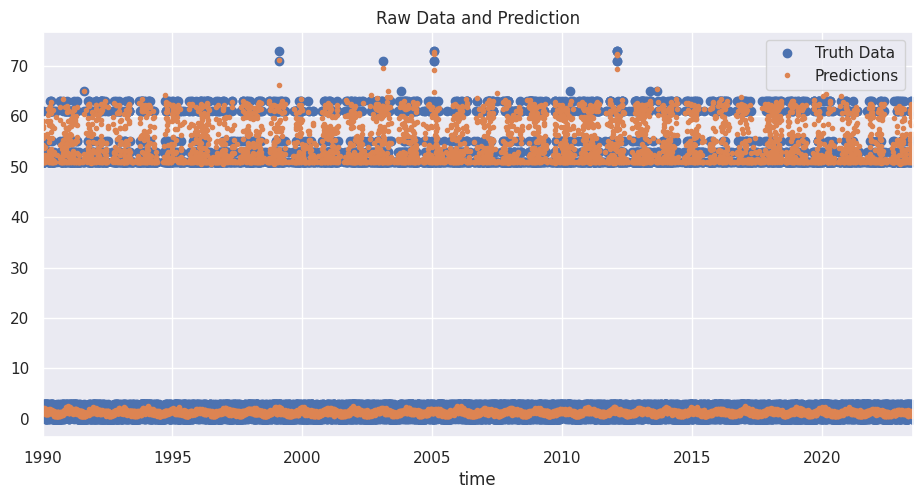

In [70]:
# 7. Seventh parameter : 'weathercode'
# a. Retrain on all data and save it
trained_model = train_all(weathercode_df, weathercode_FEATURES_Added, 'weathercode', estimator9)
# b. Use saved model to create TARGET_pred values on historical data
weathercode_df['weathercode_pred'] = param_pred(weathercode_df, 'weathercode_pred',
                                                                   'weathercode', weathercode_FEATURES_Added )
# c. Create TARGET & TARGET_pred DtataFrame
weathercode_target_df = create_target_df(weathercode_df, 'weathercode',
                                                       'weathercode_pred')
# d. Visualize TARGET Vs TARGET_Pred
data_viz(weathercode_target_df, 'weathercode', 'weathercode_pred')

# Step5: Predict and save the future values and return the forecast

## 1. Predict the future values

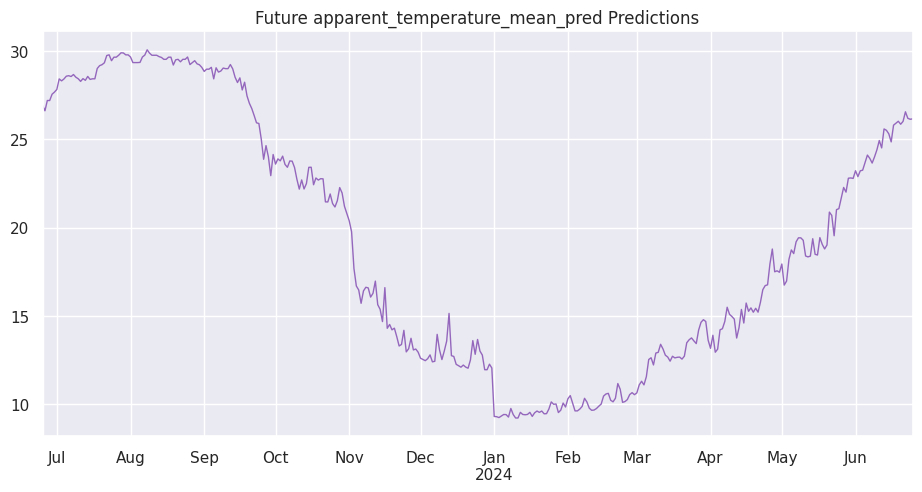

In [71]:
# 1. First parameter : apparent_temperature_mean
# a. Create future dataframe
apparent_temperature_mean_future_w_features = create_futur_df(apparent_temperature_mean_df, 'apparent_temperature_mean')
# b. Calculate future predictions
apparent_temperature_mean_future_w_features['apparent_temperature_mean_pred'] = param_pred(apparent_temperature_mean_future_w_features,
                                                                                           'apparent_temperature_mean_pred','apparent_temperature_mean',
                                                                                           apparent_temperature_mean_FEATURES_Added )
# c. Visualize predictions
future_pred_viz(apparent_temperature_mean_future_w_features, 'apparent_temperature_mean_pred')

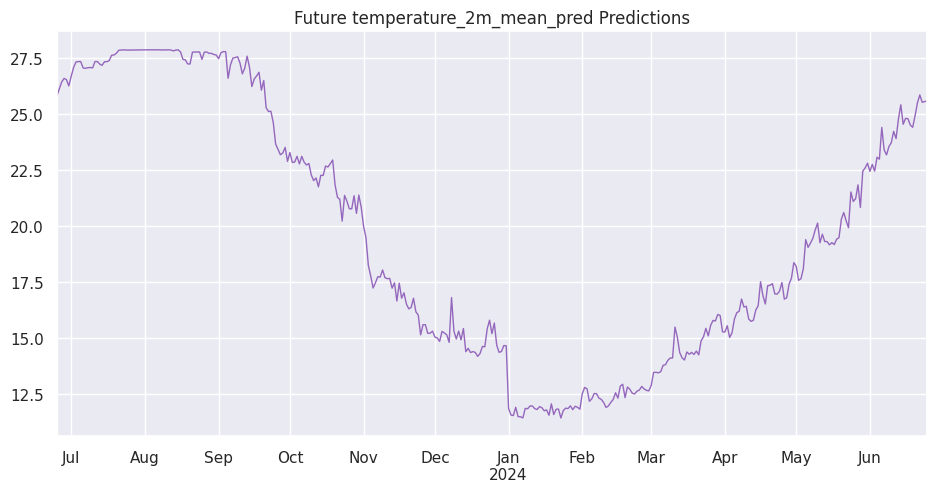

In [72]:
# 2. Second parameter : 'temperature_2m_mean'
# a. Create future dataframe
temperature_2m_mean_future_w_features = create_futur_df(temperature_2m_mean_df, 'temperature_2m_mean')
# b. Calculate future predictions
temperature_2m_mean_future_w_features['temperature_2m_mean_pred'] = param_pred(temperature_2m_mean_future_w_features,
                                                                                           'temperature_2m_mean_pred','temperature_2m_mean',
                                                                                           temperature_2m_mean_FEATURES_Added )
# c. Visualize predictions
future_pred_viz(temperature_2m_mean_future_w_features, 'temperature_2m_mean_pred')

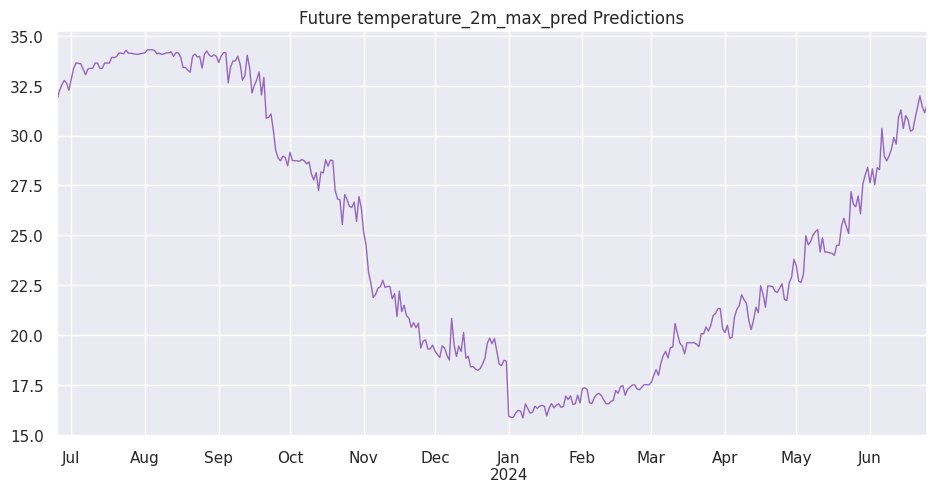

In [73]:
# 3. Third parameter : 'temperature_2m_max'
# a. Create future dataframe
temperature_2m_max_future_w_features = create_futur_df(temperature_2m_max_df, 'temperature_2m_max')
temperature_2m_max_future_w_features = temperature_2m_max_future_w_features.drop(columns=['temperature_2m_max',
                                                                                          'temperature_2m_mean',
                                                                                          'apparent_temperature_mean'])
temperature_2m_max_future_w_features = pd.concat([temperature_2m_max_future_w_features,
                                                  temperature_2m_mean_future_w_features['temperature_2m_mean_pred'],
                                                  apparent_temperature_mean_future_w_features['apparent_temperature_mean_pred']], axis=1)

new_order = ['temperature_2m_mean_pred', 'apparent_temperature_mean_pred', 'month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
             'temperature_2m_max_pred', 'isFuture']
temperature_2m_max_future_w_features = temperature_2m_max_future_w_features[new_order]
temperature_2m_max_future_w_features = temperature_2m_max_future_w_features.rename(columns={'temperature_2m_mean_pred': 'temperature_2m_mean',
                                                                                            'apparent_temperature_mean_pred': 'apparent_temperature_mean' })
# b. Calculate future predictions
temperature_2m_max_future_w_features['temperature_2m_max_pred'] = param_pred(temperature_2m_max_future_w_features,
                                                                                           'temperature_2m_max_pred','temperature_2m_max',
                                                                                           temperature_2m_max_FEATURES_Added )
# c. Visualize predictions
future_pred_viz(temperature_2m_max_future_w_features, 'temperature_2m_max_pred')

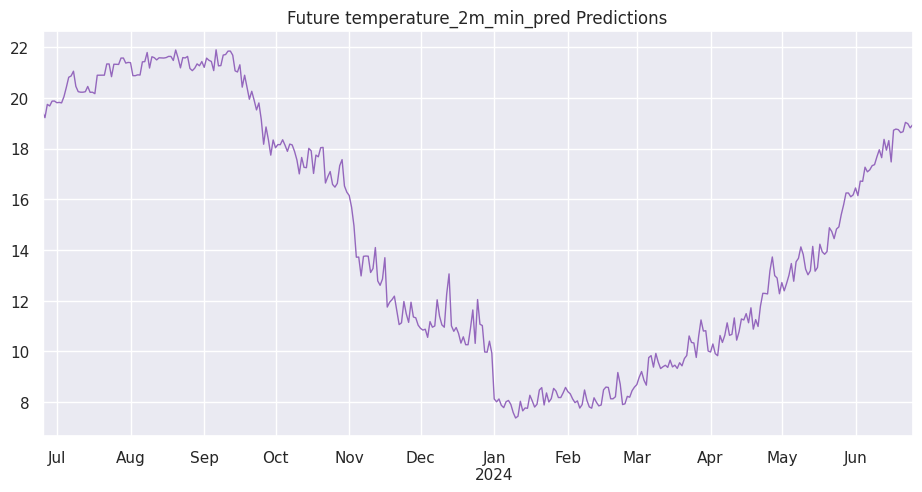

In [74]:
# 4. Forth parameter : 'temperature_2m_min'
# a. Create future dataframe
temperature_2m_min_future_w_features = create_futur_df(temperature_2m_min_df, 'temperature_2m_min')
temperature_2m_min_future_w_features = temperature_2m_min_future_w_features.drop(columns=['temperature_2m_min','temperature_2m_max',
                                                                                          'apparent_temperature_mean'])
temperature_2m_min_future_w_features = pd.concat([temperature_2m_min_future_w_features,
                                                  temperature_2m_max_future_w_features['temperature_2m_max_pred'],
                                                  apparent_temperature_mean_future_w_features['apparent_temperature_mean_pred']], axis=1)

new_order = ['temperature_2m_max_pred', 'apparent_temperature_mean_pred','month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
             'temperature_2m_min_pred', 'isFuture']
temperature_2m_min_future_w_features = temperature_2m_min_future_w_features[new_order]
temperature_2m_min_future_w_features = temperature_2m_min_future_w_features.rename(columns={'temperature_2m_max_pred': 'temperature_2m_max',
                                                                                            'apparent_temperature_mean_pred' : 'apparent_temperature_mean' })
# b. Calculate future predictions
temperature_2m_min_future_w_features['temperature_2m_min_pred'] = param_pred(temperature_2m_min_future_w_features, 'temperature_2m_min_pred',
                                                               'temperature_2m_min', temperature_2m_min_FEATURES_Added )
# c. Visualize predictions
future_pred_viz(temperature_2m_min_future_w_features, 'temperature_2m_min_pred')


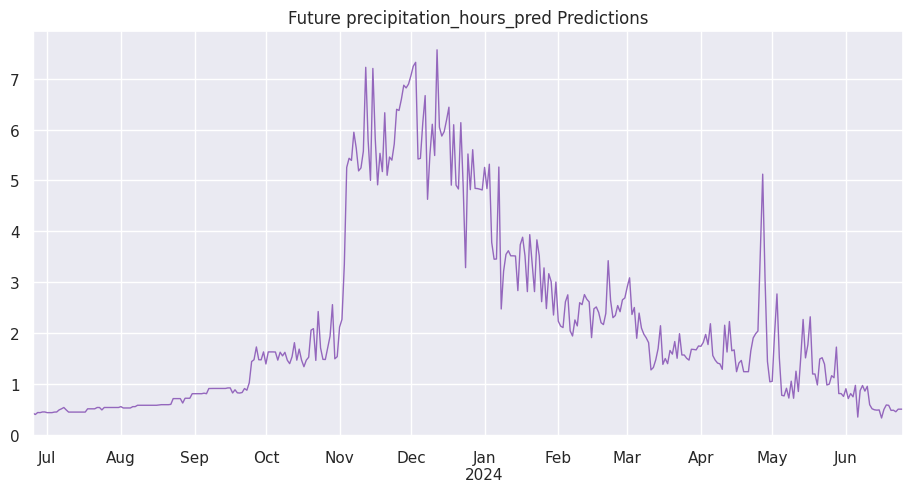

In [75]:
# 5. Fiveth parameter : 'precipitation_hours'
# e. Create future dataframe

precipitation_hours_future_w_features = create_futur_df(precipitation_hours_df, 'precipitation_hours')
precipitation_hours_future_w_features = precipitation_hours_future_w_features.drop(columns=['temperature_2m_max', 'temperature_2m_min',
                                                                                          'apparent_temperature_mean', 'precipitation_hours'])
precipitation_hours_future_w_features = pd.concat([precipitation_hours_future_w_features,
                                                  temperature_2m_max_future_w_features['temperature_2m_max_pred'],
                                                   temperature_2m_min_future_w_features['temperature_2m_min_pred'],
                                                  apparent_temperature_mean_future_w_features['apparent_temperature_mean_pred']], axis=1)
new_order = ['temperature_2m_max_pred', 'temperature_2m_min_pred' ,'apparent_temperature_mean_pred',
             'month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
             'precipitation_hours_pred', 'isFuture']
precipitation_hours_future_w_features = precipitation_hours_future_w_features[new_order]
precipitation_hours_future_w_features = precipitation_hours_future_w_features.rename(columns={'temperature_2m_max_pred': 'temperature_2m_max',
                                                                                              'temperature_2m_min_pred' : 'temperature_2m_min',
                                                                                            'apparent_temperature_mean_pred' : 'apparent_temperature_mean' })
# b. Calculate future predictions
precipitation_hours_future_w_features['precipitation_hours_pred'] = param_pred(precipitation_hours_future_w_features, 'precipitation_hours_pred',
                                                               'precipitation_hours', precipitation_hours_FEATURES_Added )
# c. Visualize predictions
future_pred_viz(precipitation_hours_future_w_features, 'precipitation_hours_pred')


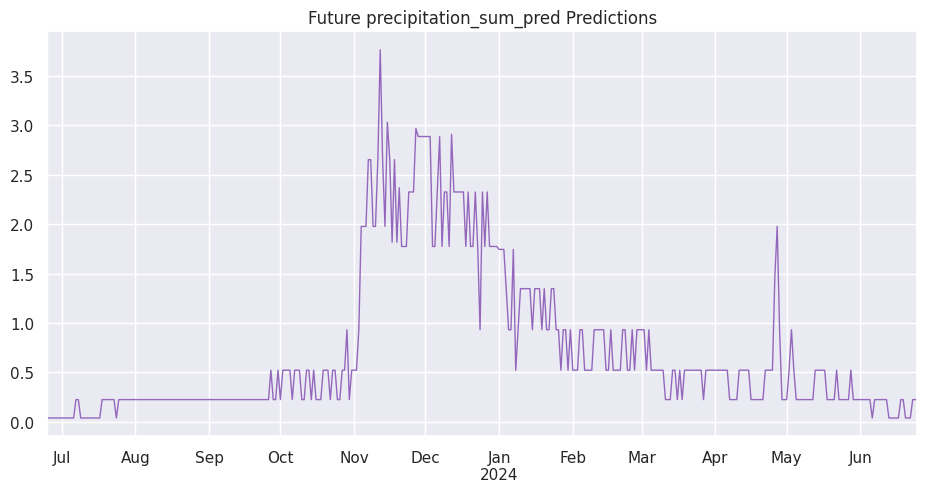

In [76]:
# 6. Sixth parameter : 'precipitation_sum'
# a. Create future dataframe

precipitation_sum_future_w_features = create_futur_df(precipitation_sum_df, 'precipitation_sum')
precipitation_sum_future_w_features = precipitation_sum_future_w_features.drop(columns=['precipitation_hours','temperature_2m_max',
                                                                                          'apparent_temperature_mean', 'precipitation_sum'])
precipitation_sum_future_w_features = pd.concat([precipitation_sum_future_w_features,
                                                  temperature_2m_max_future_w_features['temperature_2m_max_pred'],
                                                  precipitation_hours_future_w_features['precipitation_hours_pred'],
                                                  apparent_temperature_mean_future_w_features['apparent_temperature_mean_pred']], axis=1)
new_order = ['temperature_2m_max_pred',  'apparent_temperature_mean_pred','precipitation_hours_pred',
             'month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
             'precipitation_sum_pred', 'isFuture']
precipitation_sum_future_w_features = precipitation_sum_future_w_features[new_order]
precipitation_sum_future_w_features = precipitation_sum_future_w_features.rename(columns={'temperature_2m_max_pred': 'temperature_2m_max',
                                                                                          'apparent_temperature_mean_pred' : 'apparent_temperature_mean',
                                                                                          'precipitation_hours_pred' : 'precipitation_hours' })
# b. Calculate future predictions
precipitation_sum_future_w_features['precipitation_sum_pred'] = param_pred(precipitation_sum_future_w_features, 'precipitation_sum_pred',
                                                               'precipitation_sum', precipitation_sum_FEATURES_Added )
# c. Visualize predictions
future_pred_viz(precipitation_sum_future_w_features, 'precipitation_sum_pred')


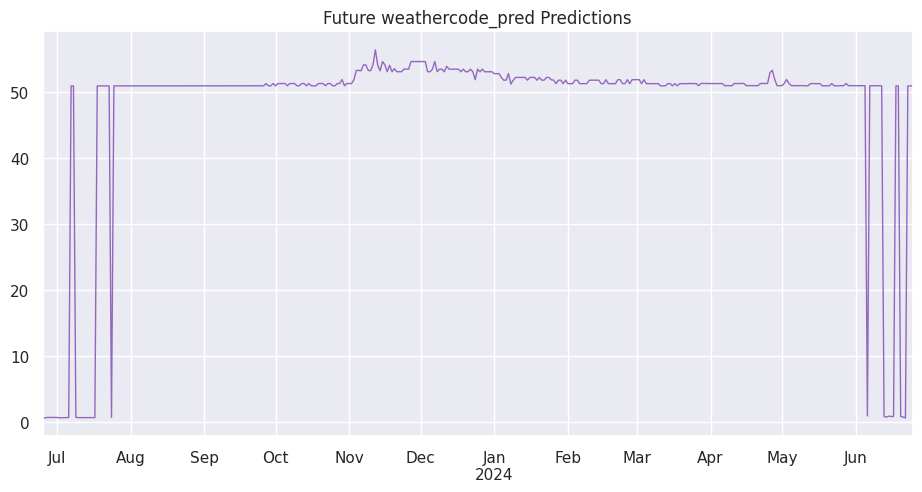

In [77]:
# 7. Seventh parameter : 'weathercode'
# a. Create future dataframe

weathercode_future_w_features = create_futur_df(weathercode_df, 'weathercode')
weathercode_future_w_features = weathercode_future_w_features.drop(columns=['precipitation_hours','temperature_2m_max', 'temperature_2m_min',
                                                                                          'apparent_temperature_mean', 'precipitation_sum'])
weathercode_future_w_features = pd.concat([weathercode_future_w_features,
                                                  temperature_2m_max_future_w_features['temperature_2m_max_pred'],
                                                  temperature_2m_min_future_w_features['temperature_2m_min_pred'],
                                                  precipitation_hours_future_w_features['precipitation_hours_pred'],
                                                  precipitation_sum_future_w_features['precipitation_sum_pred'],
                                                  apparent_temperature_mean_future_w_features['apparent_temperature_mean_pred']], axis=1)
new_order = ['temperature_2m_max_pred', 'temperature_2m_min_pred' ,'apparent_temperature_mean_pred','precipitation_hours_pred', 'precipitation_sum_pred',
             'month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
             'weathercode_pred', 'isFuture']
weathercode_future_w_features = weathercode_future_w_features[new_order]
weathercode_future_w_features = weathercode_future_w_features.rename(columns={'temperature_2m_max_pred': 'temperature_2m_max',
                                                                              'temperature_2m_min_pred': 'temperature_2m_min',
                                                                              'apparent_temperature_mean_pred' : 'apparent_temperature_mean',
                                                                              'precipitation_hours_pred' : 'precipitation_hours',
                                                                              'precipitation_sum_pred' : 'precipitation_sum'})
# b. Calculate future predictions
weathercode_future_w_features['weathercode_pred'] = param_pred(weathercode_future_w_features, 'weathercode_pred',
                                                               'weathercode', weathercode_FEATURES_Added )
# c. Visualize predictions
future_pred_viz(weathercode_future_w_features, 'weathercode_pred')

## 2. Save the future values in SQLit database

In [79]:
# a. Connect to the SQLite database
conn = sqlite3.connect('WeatherForcast_database.db')

# b. Convert DataFrame to a SQLite table
weathercode_future_w_features.to_sql('weathercode_future_w_features', conn, if_exists='replace')

# C. Close the database connection
conn.close()

## 3. Return the forecast via streamplit app

In [ ]:
import streamlit as st

header = st.beta_container()
dataset = st.beta_container()
features = st.beta_container()
model_training = st.beta_container()
@st.cache()
def request_data(url):
    weather_data = requests.get(url_API)
    if weather_data.status_code == 200:
        weather_data = json.loads(weather_data.text)
    else:
        print('The data are not available!')
    return weather_data
def create_df(weather_data):
    weather_df = pd.DataFrame()
    # Extract data from dictionary
    time = weather_data['daily']['time']
    weathercode = weather_data['daily']['weathercode']
    temperature_2m_max = weather_data['daily']['temperature_2m_max']
    temperature_2m_min = weather_data['daily']['temperature_2m_min']
    temperature_2m_mean = weather_data['daily']['temperature_2m_mean']
    apparent_temperature_mean = weather_data['daily']['apparent_temperature_mean']
    sunrise = weather_data['daily']['sunrise']
    sunset = weather_data['daily']['sunset']
    precipitation_sum = weather_data['daily']['precipitation_sum']
    precipitation_hours = weather_data['daily']['precipitation_hours']
    rain_sum = weather_data['daily']['rain_sum']
    windspeed_10m_max = weather_data['daily']['windspeed_10m_max']
    winddirection_10m_dominant = weather_data['daily']['winddirection_10m_dominant']
    # Create and add dataframe columns
    weather_df['time'] = time
    weather_df['weathercode'] = weathercode
    weather_df['temperature_2m_max'] = temperature_2m_max
    weather_df['temperature_2m_min'] = temperature_2m_min
    weather_df['temperature_2m_mean'] = temperature_2m_mean
    weather_df['apparent_temperature_mean'] = apparent_temperature_mean
    weather_df['sunrise'] = sunrise
    weather_df['sunset'] = sunset
    weather_df['precipitation_sum'] = precipitation_sum
    weather_df['precipitation_hours'] = precipitation_hours
    weather_df['rain_sum'] = rain_sum
    weather_df['windspeed_10m_max'] = windspeed_10m_max
    weather_df['winddirection_10m_dominant'] = winddirection_10m_dominant
    return weather_df


with header:
    st.title('Welcome to my first Data Science project "Weather Prediction APP"')
    st.text('I present this project in order to obtain my data science certification from GoMyCode School. \n It represent for me the opportunity to use all the knowledge I have learnt from this program to create a Weather Prediction App for the next 12 months.')

with dataset:
    st.header('The Open-Meteo Historical Weather API')
    st.text('The Historical Weather API is a free and an open-source weather API and offers free access for non-commercial use. It is based on reanalysis datasets and uses a combination of weather station, aircraft, buoy, radar, and satellite observations to create a comprehensive record of past weather conditions. These datasets are able to fill in gaps by using mathematical models to estimate the values of various weather variables.')
    st.text('To discover the All URL parameters and more details about the data documentation check the link : [API Documentation](https://open-meteo.com/en/docs/historical-weather-api)')
    url_API = "https://archive-api.open-meteo.com/v1/archive?latitude=36.6985&longitude=3.2067&start_date=1990-01-01&end_date=2023-06-25&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,precipitation_hours,windspeed_10m_max,winddirection_10m_dominant&timezone=GMT" 
    weather_data = request_data(url_API)
    weather_df= create_df(weather_data)
    st.write(weather_df.head())


